In [1]:
from Vissim_env_class import environment
from MasterDQN_Agent import MasterDQN_Agent
from collections import deque

# Network Specific Libraries
from Balance_Functions import balance_dictionary

# General Libraries
import numpy as np 
import pylab as plt
import os
import csv
import pandas as pd
import json
import pickle

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [11]:
model_name  = 'Single_Cross_Triple'
#vissim_working_directory =  'C:\\Users\\Rzhang\\Desktop\\MLforFlowOptimisationOrigine\\Vissim\\'
vissim_working_directory = "C:\\Users\\acabrejasegea\\Desktop\\15_Timescales_utc\\Timescales_and_Discount_Factor_in_UTC"

sim_length = 3601
timesteps_per_second = 1
learning_iterations = 4
actions_set = "all_actions"

agent_type = "DuelingDDQN"
Session_ID = "SCT_8ac_MemGen_Q_Range_10_gamma55"
#ession_ID = "Single_Cross_Triple8_actions_DuelingDDQN20c10"

## DQN Hyperaramenters
copy_weights_frequency = 20 # On a successfull run I copied the weight every 50
exam_frequency = 40
final_exams = 10

PER_activated = False
memory_size = 512
batch_size = 128

gamma = 0.55
alpha = 0.0001

# Source Memory partitioning
group_size = 512
overlap = 128

Random_Seed = 1

epsilon_sequence = np.zeros(5000).tolist()

# all controller actions
Single_Cross_Triple_dictionary8 =\
{\
    # Controller Number 0 
   'junctions' : {0 : {'default_actions' :  {    0 : [1,1,1,0,0,0,0,0,0,0,0,0],
                                             1 : [0,0,0,1,1,1,0,0,0,0,0,0],
                                             2 : [0,0,0,0,0,0,1,1,1,0,0,0],
                                             3 : [0,0,0,0,0,0,0,0,0,1,1,1],
                                             4 : [1,0,0,0,0,0,1,0,0,0,0,0],
                                             5 : [0,0,0,1,0,0,0,0,0,1,0,0],
                                             6 : [0,1,1,0,0,0,0,1,1,0,0,0],
                                             7 : [0,0,0,0,1,1,0,0,0,0,1,1]},
         
         'all_actions' :        {            0 : [1,1,1,0,0,0,0,0,0,0,0,0],
                                             1 : [0,0,0,1,1,1,0,0,0,0,0,0],
                                             2 : [0,0,0,0,0,0,1,1,1,0,0,0],
                                             3 : [0,0,0,0,0,0,0,0,0,1,1,1],
                                             4 : [1,0,0,0,0,0,1,0,0,0,0,0],
                                             5 : [0,0,0,1,0,0,0,0,0,1,0,0],
                                             6 : [0,1,1,0,0,0,0,1,1,0,0,0],
                                             7 : [0,0,0,0,1,1,0,0,0,0,1,1]},
 
         'link' : [1, 3, 5, 7],
         'lane' : ['1-1', '1-2', '1-3', '3-1', '3-2', '3-3', '5-1', '5-2', '5-3', '7-1', '7-2', '7-3'],
         
         'controled_by_com' : True,
         'agent_type' : agent_type,
         'green_time' : 6,
         'redamber_time' : 0,
         'amber_time' : 3, 
         'red_time' : 0,
         'state_size' : [13],
         'state_type' : 'QueuesSig',
         'reward_type' : 'Queues' ,
         'queues_counter_ID' : [1,2,3,4,5,6,7,8,9,10,11,12]             
         }
    },
   'demand' : { 'default' : [400, 400, 400, 400],
             
             0 : [300,300,300,300],
             1 : [600,600,600,600],
             2 : [1350,750,1350,750],
             3 : [1500,750,1500,750],
             4 : [1050,750,1050,750],
             5 : [750,1050,750,1050],
             6 : [750,1500,750,1500],
             7 : [750,1350,750,1350],
             8 : [600,600,600,600],
             9 : [300,300,300,300]
            }
}

In [12]:
def plot_results_train():
    ## AGENT TRAINING RESULTS
    # Path to results folder
    results_path = os.path.join(vissim_working_directory, model_name, "Agents_Results", agent_type, Session_ID)
    
    # Loop over each agent
    for idx , agent in Single_Cross_Triple8_MultiDQN_Agents.Agents.items():
        intersection_number_in_vissim = Single_Cross_Triple8_MultiDQN_Agents.Agents[0].signal_id + 1
        print("Intersection "+str(intersection_number_in_vissim))
        
        ## SAVE TRAINING DATA TO JSON.
        json_filename = "Agent{}_Loss_average_reward.json".format(intersection_number_in_vissim)
        Loss_reward = dict()   
        # Loss dictionary
        for epoch, loss in enumerate(agent.loss):
            loss_dict = { epoch : loss }
        Loss_reward['Agent{} loss'.format(intersection_number_in_vissim)] = loss_dict
        # Reward dictionary            
        episode = [i for i in range(len(agent.reward_storage))]
        Loss_reward['Agent{} Average_Reward'.format(intersection_number_in_vissim)] = agent.reward_storage
        # Store as JSON
        with open(results_path + "/" + json_filename, 'w') as f:
            json.dump(Loss_reward, f)
        print("Agent {}: Training Loss and Average Reward during training successfuly saved to file:".format(intersection_number_in_vissim))
        print(results_path + "/" + json_filename)
        
        ## LOADING DATA FROM JSON
        #results_path = os.path.join(vissim_working_directory, model_name, "Agents_Results", agent_type, Session_ID)
        #dictionary_filename = "Agent{}_Loss_average_reward.json".format(intersection_number_in_vissim)
        #with open(results_path + "/" + json_filename, 'r') as fp:
        #    data = json.load(fp)
        #print(data)
        
        ## TRAINING PLOTS
        loss_plot_filename  = "Agent{}_Loss.png".format(intersection_number_in_vissim)
        reward_plot_filename  = "Agent{}_average_reward.png".format(intersection_number_in_vissim) 
        
        ## Loss Plot
        plt.figure('LossAgent'+str(idx),figsize=(16,9))
        plt.plot(agent.loss)
        #plt.yscale('log')
    
        plt.xlabel('Training Epoch',fontsize=18)
        plt.ylabel('Loss',fontsize=18)
        plt.title('Agent {} Loss over training'.format(intersection_number_in_vissim),fontsize=18)
        plt.savefig(results_path + "/" + loss_plot_filename)
    
        ## Average Reward Plot
        plt.figure('RewardAgent'+str(idx),figsize=(16,9))
        plt.plot(agent.reward_storage)
        plt.xlabel('Training Episode',fontsize=18)
        plt.ylabel('Average reward',fontsize=18)
        plt.title('Agent {} average reward over training'.format(intersection_number_in_vissim),fontsize=18)
        plt.savefig(results_path + "/" + reward_plot_filename)

def plot_results_test(ID):
    time = [t for t in range(len(Single_Cross_Triple8_MultiDQN_Agents.Cumulative_Totale_network_stop_delay))]

    # Queues ovzer time for each junction
    for idx, queues in Single_Cross_Triple8_MultiDQN_Agents.Episode_Queues.items():
        queues = np.array(queues)
        queues = queues.T
        
        plt.figure('1'+str(idx),figsize=(16, 9))
        
        Queuesdf = pd.DataFrame()
        
        Queuesdf['Time'] = time
        Queues_legend = []
        
        for i, queue in enumerate(queues):
            plt.plot(queue, label = "Queue"+str(i))
            Queuesdf[str(i)] = queue
            Queues_legend.append("Queue"+str(i))
            
        plt.xlabel('Time [s]',fontsize=18)
        plt.ylabel('Queue Length',fontsize=18)
        plt.title('Junction {} Queue length'.format(idx),fontsize=18)
        #plt.gca().legend(Queues_legend)
        
        Path = os.path.join(vissim_working_directory, model_name, "Agents_Results", agent_type, Session_ID,\
                            "Junction{}_Queues_{}.png".format(idx,ID))               
        plt.savefig(Path)
        
        csv_Path = os.path.join(vissim_working_directory, model_name, "Agents_Results", agent_type, Session_ID,\
                            "Junction{}_Queues_{}.csv".format(idx,ID))        
       
        Queuesdf.to_csv(csv_Path,index=False)
        plt.legend()
            
            
    # Accumulated delay over time for each junction
    for idx, delay in Single_Cross_Triple8_MultiDQN_Agents.Cumulative_Episode_Delays.items():
        
        plt.figure('2'+str(idx),figsize=(16, 9))
        
        delaydf = pd.DataFrame()   
        delaydf['Time'] = time
        delaydf['Junction {} delay'.format(idx)] = delay
        
        plt.plot(delay)
        plt.xlabel('Time [s]',fontsize=18)
        plt.ylabel('Accumulated Delay',fontsize=18)
        plt.title('Junction {} Delay'.format(idx),fontsize=18)
        plt.gca().legend('Junction accumulated delay')
        
        Path = os.path.join(vissim_working_directory, model_name, "Agents_Results", agent_type, Session_ID,\
                                "Junction{}_Cumulative_Delay_{}.png".format(idx,ID))
        csv_Path = os.path.join(vissim_working_directory, model_name, "Agents_Results", agent_type, Session_ID,\
                            "Junction{}_Cumulative_Delay_{}.csv".format(idx,ID))   
        plt.savefig(Path)
        delaydf.to_csv(csv_Path,index=False)
        
        
    # Accumulated stop delay over time for each junction
    for idx, stop_delay in Single_Cross_Triple8_MultiDQN_Agents.Cumulative_Episode_stop_Delays.items():
        
        plt.figure('3'+str(idx),figsize=(16, 9))
        
        stop_delaydf = pd.DataFrame()   
        stop_delaydf['Time'] = time
        stop_delaydf['Junction {} stop delay'.format(idx)] = stop_delay
    
        plt.plot(stop_delay)
        plt.xlabel('Time [s]',fontsize=18)
        plt.ylabel('Accumulated Stop Delay',fontsize=18)
        plt.title('Junction {} Stop Delay'.format(idx),fontsize=18)
        plt.gca().legend('Junction accumulated Stop delay')
        
        Path = os.path.join(vissim_working_directory, model_name, "Agents_Results", agent_type, Session_ID,\
                                "Junction{}_Cumulative_stop_Delay_{}.png".format(idx,ID))
        csv_Path = os.path.join(vissim_working_directory, model_name, "Agents_Results", agent_type, Session_ID,\
                            "Junction{}_Cumulative_stop_Delay_{}.csv".format(idx,ID))
        plt.savefig(Path)
        stop_delaydf.to_csv(csv_Path,index=False)

In [13]:
Single_Cross_Triple8_MultiDQN_Agents = MasterDQN_Agent(model_name, vissim_working_directory,\
                                                       sim_length, Single_Cross_Triple_dictionary8,\
                                                       actions_set, gamma, alpha, agent_type,\
                                                       memory_size, PER_activated, batch_size,\
                                                       learning_iterations, copy_weights_frequency,\
                                                       epsilon_sequence,Random_Seed,\
                                                       timesteps_per_second, Session_ID,\
                                                       verbose = True)

INTERSECTION 0: SETTING UP AGENT
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 13)]         0                                            
__________________________________________________________________________________________________
dense_24 (Dense)                (None, 48)           672         input_5[0][0]                    
__________________________________________________________________________________________________
dense_25 (Dense)                (None, 48)           2352        dense_24[0][0]                   
__________________________________________________________________________________________________
dense_28 (Dense)                (None, 48)           2352        dense_25[0][0]                   
___________________________________________________________

In [14]:
# Load external memory
#
#############################################
# external_memory[i]    = i-th memory       #
# external_memory[i][0] = i-th state        #
# external_memory[i][1] = i-th action       #
# external_memory[i][2] = i-th reward       #
# external_memory[i][3] = i-th next_state   # 
# external_memory[i][4] = done?             #
#############################################

filename1 = os.path.join(vissim_working_directory, model_name, "Agents_Results", agent_type, Session_ID) + "\\memoryD3QN_400.pkl"
print("Attempting to load file:")
print(filename1 + "\n")
initial_memory = list(pickle.load(open(filename1, 'rb')))
print("400 Memory Loaded Successfully")
partitioned_initial_memory= [initial_memory[i:i+group_size] for i in range(0, len(initial_memory), group_size-overlap)]
print("400 Memory is comprised of {} groups \n".format(len(partitioned_initial_memory)))
low_demand_limit = len(partitioned_initial_memory)

#############################################
filename = os.path.join(vissim_working_directory, model_name, "Agents_Results", agent_type, Session_ID) + "\\memoryD3QN_600.pkl"
print("Attempting to load file:")
print(filename + "\n")
memory2 = list(pickle.load(open(filename, 'rb')))
print("600 Long Memory Loaded Successfully")
partitioned_memory2= [memory2[i:i+group_size] for i in range(0, len(memory2), group_size-overlap)]
print("600 Long Memory Partitioned Successfully into {} groups \n".format(len(partitioned_memory2)))
mid_demand_limit =  len(partitioned_memory2)

#############################################
filename2 = os.path.join(vissim_working_directory, model_name, "Agents_Results", agent_type, Session_ID) + "\\memoryD3QN_800.pkl"
print("Attempting to load file:")
print(filename2 + "\n")
memory = list(pickle.load(open(filename2, 'rb')))
print("800 Memory Loaded Successfully")
partitioned_memory= [memory[i:i+group_size] for i in range(0, len(memory), group_size-overlap)]
print("800 Memory is comprised of {} groups \n".format(len(partitioned_memory)))
total_episodes = len(partitioned_memory)

Attempting to load file:
C:\Users\acabrejasegea\Desktop\15_Timescales_utc\Timescales_and_Discount_Factor_in_UTC\Single_Cross_Triple\Agents_Results\DuelingDDQN\SCT_8ac_MemGen_Q_Range_10_gamma55\memoryD3QN_400.pkl

400 Memory Loaded Successfully
400 Memory is comprised of 1092 groups 

Attempting to load file:
C:\Users\acabrejasegea\Desktop\15_Timescales_utc\Timescales_and_Discount_Factor_in_UTC\Single_Cross_Triple\Agents_Results\DuelingDDQN\SCT_8ac_MemGen_Q_Range_10_gamma55\memoryD3QN_600.pkl

600 Long Memory Loaded Successfully
600 Long Memory Partitioned Successfully into 2236 groups 

Attempting to load file:
C:\Users\acabrejasegea\Desktop\15_Timescales_utc\Timescales_and_Discount_Factor_in_UTC\Single_Cross_Triple\Agents_Results\DuelingDDQN\SCT_8ac_MemGen_Q_Range_10_gamma55\memoryD3QN_800.pkl

800 Memory Loaded Successfully
800 Memory is comprised of 3406 groups 



In [16]:
partitioned_initial_memory[1]

[[array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
           0.        ,  5.80167286, 23.27689823,  0.        ,  0.        ,
           5.09724134,  5.22577022,  5.        ]]),
  5,
  -0.04142546201986011,
  array([[ 0.        ,  0.        ,  0.        ,  0.        ,  6.70223456,
           0.        ,  0.        , 33.25191821,  5.85625681,  5.6830438 ,
           9.44039732, 13.63198094,  4.        ]]),
  False],
 [array([[ 0.        ,  0.        ,  0.        ,  0.        ,  6.70223456,
           0.        ,  0.        , 33.25191821,  5.85625681,  5.6830438 ,
           9.44039732, 13.63198094,  4.        ]]),
  4,
  -0.039678878911518466,
  array([[ 0.        ,  0.        ,  0.        ,  0.        ,  5.7429332 ,
           0.        ,  0.        , 30.83374679,  6.36086584,  5.59010304,
          11.71487174, 11.17946144,  2.        ]]),
  False],
 [array([[ 0.        ,  0.        ,  0.        ,  0.        ,  5.7429332 ,
           0.        ,  0.        , 30

Working Directory set to: C:\Users\acabrejasegea\Desktop\15_Timescales_utc\Timescales_and_Discount_Factor_in_UTC
Generating Cache...
Cache generated.

****************************
*   COM Server dispatched  *
****************************

Attempting to load Model File: Single_Cross_Triple.inpx ...
Failed load attempt 1/5. Re-attempting.
Working Directory set to: C:\Users\acabrejasegea\Desktop\15_Timescales_utc\Timescales_and_Discount_Factor_in_UTC
Generating Cache...
Cache generated.

****************************
*   COM Server dispatched  *
****************************

Attempting to load Model File: Single_Cross_Triple.inpx ...
Model File load process successful.
Simulation length set to 3601 seconds.
Results from Previous Simulations: Deleted. Fresh Start Available.
Fetched and containerized Network Object 

*******************************************************
*                                                     *
*                COM SETUP COMPLETE                   *
*        

1/1 - 0s - loss: 0.7772
1/1 - 0s - loss: 0.8619
1/1 - 0s - loss: 0.7986
1/1 - 0s - loss: 0.9040
Round 32/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 1.3377
1/1 - 0s - loss: 1.1914
1/1 - 0s - loss: 0.8671
1/1 - 0s - loss: 1.0509
Round 33/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.6999
1/1 - 0s - loss: 0.7657
1/1 - 0s - loss: 0.8531
1/1 - 0s - loss: 0.8985
Round 34/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.7589
1/1 - 0s - loss: 1.5386
1/1 - 0s - loss: 1.3433
1/1 - 0s - loss: 1.0437
Round 35/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 1.4587
1/1 - 0s - loss: 1.0890
1/1 - 0s - loss: 1.1235
1/1 - 0s - loss: 1.1393
Round 36/3405: Adding 512 memories from Deque into Agent
Mem

1/1 - 0s - loss: 0.5857
1/1 - 0s - loss: 0.4718
1/1 - 0s - loss: 0.5005
1/1 - 0s - loss: 0.4753
Round 70/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.4534
1/1 - 0s - loss: 0.5721
1/1 - 0s - loss: 0.6653
1/1 - 0s - loss: 0.3827
Round 71/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.6269
1/1 - 0s - loss: 0.4983
1/1 - 0s - loss: 0.5302
1/1 - 0s - loss: 0.5319
Round 72/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.4029
1/1 - 0s - loss: 0.4010
1/1 - 0s - loss: 0.3586
1/1 - 0s - loss: 0.3974
Round 73/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.6244
1/1 - 0s - loss: 0.4850
1/1 - 0s - loss: 0.4628
1/1 - 0s - loss: 0.5068
Round 74/3405: Adding 512 memories from Deque into Agent
Mem

1/1 - 0s - loss: 0.2102
1/1 - 0s - loss: 0.2625
1/1 - 0s - loss: 0.2123
1/1 - 0s - loss: 0.2311
Round 108/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.4785
1/1 - 0s - loss: 0.4146
1/1 - 0s - loss: 0.4319
1/1 - 0s - loss: 0.5227
Round 109/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.6488
1/1 - 0s - loss: 0.5974
1/1 - 0s - loss: 0.5020
1/1 - 0s - loss: 0.4448
Round 110/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.4102
1/1 - 0s - loss: 0.3595
1/1 - 0s - loss: 0.4850
1/1 - 0s - loss: 0.2951
Round 111/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.3845
1/1 - 0s - loss: 0.5103
1/1 - 0s - loss: 0.3963
1/1 - 0s - loss: 0.2995
Round 112/3405: Adding 512 memories from Deque into Agen

1/1 - 0s - loss: 0.2463
1/1 - 0s - loss: 0.2440
1/1 - 0s - loss: 0.2505
1/1 - 0s - loss: 0.2681
Round 146/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.3603
1/1 - 0s - loss: 0.2903
1/1 - 0s - loss: 0.3585
1/1 - 0s - loss: 0.3474
Round 147/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2488
1/1 - 0s - loss: 0.2693
1/1 - 0s - loss: 0.3333
1/1 - 0s - loss: 0.2472
Round 148/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.4116
1/1 - 0s - loss: 0.2437
1/1 - 0s - loss: 0.2519
1/1 - 0s - loss: 0.2633
Round 149/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2938
1/1 - 0s - loss: 0.2620
1/1 - 0s - loss: 0.2687
1/1 - 0s - loss: 0.2947
Round 150/3405: Adding 512 memories from Deque into Agen

1/1 - 0s - loss: 0.3582
1/1 - 0s - loss: 0.3800
1/1 - 0s - loss: 0.3333
1/1 - 0s - loss: 0.3914
Round 184/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2614
1/1 - 0s - loss: 0.3600
1/1 - 0s - loss: 0.2766
1/1 - 0s - loss: 0.3365
Round 185/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2355
1/1 - 0s - loss: 0.1952
1/1 - 0s - loss: 0.2907
1/1 - 0s - loss: 0.2843
Round 186/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2268
1/1 - 0s - loss: 0.2663
1/1 - 0s - loss: 0.2775
1/1 - 0s - loss: 0.2484
Round 187/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.3336
1/1 - 0s - loss: 0.3303
1/1 - 0s - loss: 0.3695
1/1 - 0s - loss: 0.2887
Round 188/3405: Adding 512 memories from Deque into Agen

1/1 - 0s - loss: 0.3176
1/1 - 0s - loss: 0.2648
1/1 - 0s - loss: 0.2661
1/1 - 0s - loss: 0.2798
Round 222/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2158
1/1 - 0s - loss: 0.2492
1/1 - 0s - loss: 0.2163
1/1 - 0s - loss: 0.2737
Round 223/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2385
1/1 - 0s - loss: 0.2001
1/1 - 0s - loss: 0.2468
1/1 - 0s - loss: 0.2414
Round 224/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2211
1/1 - 0s - loss: 0.1880
1/1 - 0s - loss: 0.1938
1/1 - 0s - loss: 0.2152
Round 225/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2293
1/1 - 0s - loss: 0.2075
1/1 - 0s - loss: 0.2058
1/1 - 0s - loss: 0.2130
Round 226/3405: Adding 512 memories from Deque into Agen

1/1 - 0s - loss: 0.1818
1/1 - 0s - loss: 0.2163
1/1 - 0s - loss: 0.2312
Round 260/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1784
1/1 - 0s - loss: 0.2225
1/1 - 0s - loss: 0.1865
1/1 - 0s - loss: 0.2014
Weights succesfully copied to Target model for Agent 0.
Round 261/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2193
1/1 - 0s - loss: 0.2217
1/1 - 0s - loss: 0.1930
1/1 - 0s - loss: 0.1844
Round 262/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2110
1/1 - 0s - loss: 0.2451
1/1 - 0s - loss: 0.2458
1/1 - 0s - loss: 0.2139
Round 263/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2237
1/1 - 0s - loss: 0.2250
1/1 - 0s - loss: 0.1826
1/1 - 0s - loss: 0.2286
Round 264/3405: Adding 5

1/1 - 0s - loss: 0.4827
1/1 - 0s - loss: 0.5618
1/1 - 0s - loss: 0.4579
1/1 - 0s - loss: 0.3913
Round 298/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.3704
1/1 - 0s - loss: 0.3942
1/1 - 0s - loss: 0.2894
1/1 - 0s - loss: 0.3709
Round 299/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.3453
1/1 - 0s - loss: 0.3753
1/1 - 0s - loss: 0.2551
1/1 - 0s - loss: 0.2257
Round 300/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2498
1/1 - 0s - loss: 0.2275
1/1 - 0s - loss: 0.2127
1/1 - 0s - loss: 0.2340
Weights succesfully copied to Target model for Agent 0.
Round 301/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2384
1/1 - 0s - loss: 0.2033
1/1 - 0s - loss: 0.1878
1/1 - 0s - loss: 0.2111


1/1 - 0s - loss: 0.5094
1/1 - 0s - loss: 0.5001
1/1 - 0s - loss: 0.3892
1/1 - 0s - loss: 0.3460
Round 336/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2672
1/1 - 0s - loss: 0.2905
1/1 - 0s - loss: 0.3233
1/1 - 0s - loss: 0.2676
Round 337/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.3083
1/1 - 0s - loss: 0.2564
1/1 - 0s - loss: 0.3158
1/1 - 0s - loss: 0.2666
Round 338/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2675
1/1 - 0s - loss: 0.2505
1/1 - 0s - loss: 0.2171
1/1 - 0s - loss: 0.2887
Round 339/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.3017
1/1 - 0s - loss: 0.2772
1/1 - 0s - loss: 0.2641
1/1 - 0s - loss: 0.2844
Round 340/3405: Adding 512 memories from Deque into Agen

1/1 - 0s - loss: 0.1813
1/1 - 0s - loss: 0.2070
1/1 - 0s - loss: 0.2071
1/1 - 0s - loss: 0.2263
Round 374/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1783
1/1 - 0s - loss: 0.1774
1/1 - 0s - loss: 0.1974
1/1 - 0s - loss: 0.2115
Round 375/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1621
1/1 - 0s - loss: 0.1844
1/1 - 0s - loss: 0.1878
1/1 - 0s - loss: 0.1601
Round 376/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2028
1/1 - 0s - loss: 0.2386
1/1 - 0s - loss: 0.1811
1/1 - 0s - loss: 0.2079
Round 377/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2043
1/1 - 0s - loss: 0.1949
1/1 - 0s - loss: 0.1785
1/1 - 0s - loss: 0.1596
Round 378/3405: Adding 512 memories from Deque into Agen

1/1 - 0s - loss: 0.4104
1/1 - 0s - loss: 0.3064
1/1 - 0s - loss: 0.2577
1/1 - 0s - loss: 0.4209
Round 412/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.3354
1/1 - 0s - loss: 0.3210
1/1 - 0s - loss: 0.3446
1/1 - 0s - loss: 0.3939
Round 413/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.5136
1/1 - 0s - loss: 0.5192
1/1 - 0s - loss: 0.4292
1/1 - 0s - loss: 0.5391
Round 414/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.3091
1/1 - 0s - loss: 0.2812
1/1 - 0s - loss: 0.3090
1/1 - 0s - loss: 0.2711
Round 415/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2554
1/1 - 0s - loss: 0.1944
1/1 - 0s - loss: 0.1869
1/1 - 0s - loss: 0.2148
Round 416/3405: Adding 512 memories from Deque into Agen

1/1 - 0s - loss: 0.3522
1/1 - 0s - loss: 0.3837
1/1 - 0s - loss: 0.4094
1/1 - 0s - loss: 0.3448
Round 450/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.3844
1/1 - 0s - loss: 0.4205
1/1 - 0s - loss: 0.4491
1/1 - 0s - loss: 0.4172
Round 451/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2674
1/1 - 0s - loss: 0.2480
1/1 - 0s - loss: 0.2255
1/1 - 0s - loss: 0.2475
Round 452/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2369
1/1 - 0s - loss: 0.1937
1/1 - 0s - loss: 0.2068
1/1 - 0s - loss: 0.2075
Round 453/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.3254
1/1 - 0s - loss: 0.2669
1/1 - 0s - loss: 0.2440
1/1 - 0s - loss: 0.2255
Round 454/3405: Adding 512 memories from Deque into Agen

1/1 - 0s - loss: 0.3216
1/1 - 0s - loss: 0.2751
1/1 - 0s - loss: 0.2666
1/1 - 0s - loss: 0.2595
Round 488/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.6004
1/1 - 0s - loss: 0.4759
1/1 - 0s - loss: 0.5021
1/1 - 0s - loss: 0.4192
Round 489/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.3717
1/1 - 0s - loss: 0.3851
1/1 - 0s - loss: 0.3482
1/1 - 0s - loss: 0.3505
Round 490/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2742
1/1 - 0s - loss: 0.2402
1/1 - 0s - loss: 0.2478
1/1 - 0s - loss: 0.2332
Round 491/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.3783
1/1 - 0s - loss: 0.3479
1/1 - 0s - loss: 0.2920
1/1 - 0s - loss: 0.3251
Round 492/3405: Adding 512 memories from Deque into Agen

1/1 - 0s - loss: 0.3355
1/1 - 0s - loss: 0.4066
1/1 - 0s - loss: 0.2847
1/1 - 0s - loss: 0.2705
Round 526/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.3915
1/1 - 0s - loss: 0.3151
1/1 - 0s - loss: 0.2579
1/1 - 0s - loss: 0.3088
Round 527/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2874
1/1 - 0s - loss: 0.2734
1/1 - 0s - loss: 0.2393
1/1 - 0s - loss: 0.2186
Round 528/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.4348
1/1 - 0s - loss: 0.5004
1/1 - 0s - loss: 0.4472
1/1 - 0s - loss: 0.3684
Round 529/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2977
1/1 - 0s - loss: 0.2636
1/1 - 0s - loss: 0.2790
1/1 - 0s - loss: 0.1796
Round 530/3405: Adding 512 memories from Deque into Agen

1/1 - 0s - loss: 0.4004
1/1 - 0s - loss: 0.4170
1/1 - 0s - loss: 0.3909
1/1 - 0s - loss: 0.3109
Round 564/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.4410
1/1 - 0s - loss: 0.4695
1/1 - 0s - loss: 0.4594
1/1 - 0s - loss: 0.3346
Round 565/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.3633
1/1 - 0s - loss: 0.3206
1/1 - 0s - loss: 0.4284
1/1 - 0s - loss: 0.4213
Round 566/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.6117
1/1 - 0s - loss: 0.6029
1/1 - 0s - loss: 0.5150
1/1 - 0s - loss: 0.3358
Round 567/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 1.1619
1/1 - 0s - loss: 1.2196
1/1 - 0s - loss: 0.9524
1/1 - 0s - loss: 0.7469
Round 568/3405: Adding 512 memories from Deque into Agen

1/1 - 0s - loss: 1.5133
1/1 - 0s - loss: 1.1732
1/1 - 0s - loss: 1.0260
Round 602/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 1.0867
1/1 - 0s - loss: 0.9416
1/1 - 0s - loss: 0.9987
1/1 - 0s - loss: 0.6393
Round 603/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.7669
1/1 - 0s - loss: 0.5074
1/1 - 0s - loss: 0.9274
1/1 - 0s - loss: 0.5906
Round 604/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2905
1/1 - 0s - loss: 0.2894
1/1 - 0s - loss: 0.2737
1/1 - 0s - loss: 0.2824
Round 605/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.3854
1/1 - 0s - loss: 0.3667
1/1 - 0s - loss: 0.4413
1/1 - 0s - loss: 0.3833
Round 606/3405: Adding 512 memories from Deque into Agent
Memories succesfully l

1/1 - 0s - loss: 0.9204
1/1 - 0s - loss: 0.8084
1/1 - 0s - loss: 0.7767
1/1 - 0s - loss: 0.7801
Weights succesfully copied to Target model for Agent 0.
Starting exam run...

Evaluation 17: Finished. Average Reward: -2120.28
Round 641/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.8429
1/1 - 0s - loss: 0.8097
1/1 - 0s - loss: 0.5831
1/1 - 0s - loss: 0.4952
Round 642/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.9276
1/1 - 0s - loss: 0.7090
1/1 - 0s - loss: 0.3565
1/1 - 0s - loss: 0.2668
Round 643/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2958
1/1 - 0s - loss: 0.2852
1/1 - 0s - loss: 0.3816
1/1 - 0s - loss: 0.3592
Round 644/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.5760


1/1 - 0s - loss: 0.3933
1/1 - 0s - loss: 0.3725
1/1 - 0s - loss: 0.3009
1/1 - 0s - loss: 0.2884
Round 679/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.5648
1/1 - 0s - loss: 0.6084
1/1 - 0s - loss: 0.7511
1/1 - 0s - loss: 0.7127
Round 680/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2839
1/1 - 0s - loss: 0.2633
1/1 - 0s - loss: 0.2236
1/1 - 0s - loss: 0.2447
Weights succesfully copied to Target model for Agent 0.
Starting exam run...

Evaluation 18: Finished. Average Reward: -2017.88
Round 681/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.5194
1/1 - 0s - loss: 0.3584
1/1 - 0s - loss: 0.6644
1/1 - 0s - loss: 0.8288
Round 682/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.4952


1/1 - 0s - loss: 0.8803
1/1 - 0s - loss: 0.7975
1/1 - 0s - loss: 0.4432
1/1 - 0s - loss: 0.4641
Round 717/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.4131
1/1 - 0s - loss: 0.5653
1/1 - 0s - loss: 0.6807
1/1 - 0s - loss: 0.6403
Round 718/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.5202
1/1 - 0s - loss: 0.3951
1/1 - 0s - loss: 0.3065
1/1 - 0s - loss: 0.2348
Round 719/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2106
1/1 - 0s - loss: 0.3863
1/1 - 0s - loss: 0.2868
1/1 - 0s - loss: 0.3470
Round 720/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.4270
1/1 - 0s - loss: 0.3112
1/1 - 0s - loss: 0.4064
1/1 - 0s - loss: 0.3542
Weights succesfully copied to Target model for Agent 0.


1/1 - 0s - loss: 0.4492
1/1 - 0s - loss: 0.5321
1/1 - 0s - loss: 0.4355
1/1 - 0s - loss: 0.4164
Round 755/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.5627
1/1 - 0s - loss: 0.6005
1/1 - 0s - loss: 0.5577
1/1 - 0s - loss: 0.5189
Round 756/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 1.1327
1/1 - 0s - loss: 0.9611
1/1 - 0s - loss: 0.8250
1/1 - 0s - loss: 0.5440
Round 757/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 1.6389
1/1 - 0s - loss: 1.0444
1/1 - 0s - loss: 1.0227
1/1 - 0s - loss: 0.9178
Round 758/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.4279
1/1 - 0s - loss: 0.5075
1/1 - 0s - loss: 0.6357
1/1 - 0s - loss: 0.6717
Round 759/3405: Adding 512 memories from Deque into Agen

1/1 - 0s - loss: 0.6436
1/1 - 0s - loss: 0.8526
1/1 - 0s - loss: 0.7436
1/1 - 0s - loss: 0.9789
Round 793/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.9714
1/1 - 0s - loss: 0.9712
1/1 - 0s - loss: 0.8681
1/1 - 0s - loss: 0.9645
Round 794/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 2.3550
1/1 - 0s - loss: 1.3669
1/1 - 0s - loss: 1.0523
1/1 - 0s - loss: 0.7481
Round 795/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 1.0681
1/1 - 0s - loss: 0.7930
1/1 - 0s - loss: 1.1137
1/1 - 0s - loss: 1.3078
Round 796/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.6568
1/1 - 0s - loss: 0.5800
1/1 - 0s - loss: 0.4473
1/1 - 0s - loss: 0.4301
Round 797/3405: Adding 512 memories from Deque into Agen

1/1 - 0s - loss: 1.0148
1/1 - 0s - loss: 0.8093
1/1 - 0s - loss: 0.8487
1/1 - 0s - loss: 0.8646
Round 831/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.5628
1/1 - 0s - loss: 0.6348
1/1 - 0s - loss: 0.5265
1/1 - 0s - loss: 0.6270
Round 832/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.6219
1/1 - 0s - loss: 0.6675
1/1 - 0s - loss: 0.5546
1/1 - 0s - loss: 0.5561
Round 833/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.8962
1/1 - 0s - loss: 0.9467
1/1 - 0s - loss: 0.6456
1/1 - 0s - loss: 0.6144
Round 834/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.8294
1/1 - 0s - loss: 0.7435
1/1 - 0s - loss: 0.5498
1/1 - 0s - loss: 0.6437
Round 835/3405: Adding 512 memories from Deque into Agen

1/1 - 0s - loss: 1.0597
1/1 - 0s - loss: 0.9987
1/1 - 0s - loss: 1.0518
1/1 - 0s - loss: 0.7500
Round 869/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.6900
1/1 - 0s - loss: 0.5569
1/1 - 0s - loss: 0.6032
1/1 - 0s - loss: 0.4261
Round 870/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.3762
1/1 - 0s - loss: 0.4665
1/1 - 0s - loss: 0.4782
1/1 - 0s - loss: 0.3361
Round 871/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 2.1768
1/1 - 0s - loss: 1.8036
1/1 - 0s - loss: 0.8519
1/1 - 0s - loss: 0.6599
Round 872/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 1.7388
1/1 - 0s - loss: 1.8038
1/1 - 0s - loss: 1.8683
1/1 - 0s - loss: 1.7101
Round 873/3405: Adding 512 memories from Deque into Agen

1/1 - 0s - loss: 0.5618
1/1 - 0s - loss: 0.3418
1/1 - 0s - loss: 0.3977
1/1 - 0s - loss: 0.3617
Round 907/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 2.0774
1/1 - 0s - loss: 2.2833
1/1 - 0s - loss: 1.0683
1/1 - 0s - loss: 0.9939
Round 908/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.5187
1/1 - 0s - loss: 0.4357
1/1 - 0s - loss: 0.3240
1/1 - 0s - loss: 0.2446
Round 909/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.3812
1/1 - 0s - loss: 0.4175
1/1 - 0s - loss: 0.3777
1/1 - 0s - loss: 0.3387
Round 910/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.4232
1/1 - 0s - loss: 0.5177
1/1 - 0s - loss: 0.3754
1/1 - 0s - loss: 0.3144
Round 911/3405: Adding 512 memories from Deque into Agen

1/1 - 0s - loss: 1.4809
1/1 - 0s - loss: 2.1078
1/1 - 0s - loss: 2.2518
1/1 - 0s - loss: 1.7726
Round 945/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.5656
1/1 - 0s - loss: 0.6042
1/1 - 0s - loss: 0.8130
1/1 - 0s - loss: 0.9487
Round 946/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.3098
1/1 - 0s - loss: 0.3100
1/1 - 0s - loss: 0.2564
1/1 - 0s - loss: 0.2101
Round 947/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 1.1340
1/1 - 0s - loss: 0.9967
1/1 - 0s - loss: 0.9117
1/1 - 0s - loss: 0.8418
Round 948/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.7409
1/1 - 0s - loss: 0.7809
1/1 - 0s - loss: 0.9010
1/1 - 0s - loss: 0.5465
Round 949/3405: Adding 512 memories from Deque into Agen

1/1 - 0s - loss: 1.0430
1/1 - 0s - loss: 1.0339
1/1 - 0s - loss: 1.1473
1/1 - 0s - loss: 0.9406
Round 983/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2571
1/1 - 0s - loss: 0.3541
1/1 - 0s - loss: 0.2609
1/1 - 0s - loss: 0.2725
Round 984/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2890
1/1 - 0s - loss: 0.3009
1/1 - 0s - loss: 0.2745
1/1 - 0s - loss: 0.2172
Round 985/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.4785
1/1 - 0s - loss: 0.4476
1/1 - 0s - loss: 0.3393
1/1 - 0s - loss: 0.3185
Round 986/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.7138
1/1 - 0s - loss: 0.8368
1/1 - 0s - loss: 0.5390
1/1 - 0s - loss: 0.4795
Round 987/3405: Adding 512 memories from Deque into Agen

1/1 - 0s - loss: 1.1023
1/1 - 0s - loss: 1.1260
1/1 - 0s - loss: 0.7552
1/1 - 0s - loss: 0.5198
Weights succesfully copied to Target model for Agent 0.
Round 1021/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 1.2251
1/1 - 0s - loss: 0.9242
1/1 - 0s - loss: 0.8034
1/1 - 0s - loss: 1.0041
Round 1022/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.3620
1/1 - 0s - loss: 0.6635
1/1 - 0s - loss: 0.4426
1/1 - 0s - loss: 0.5782
Round 1023/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.7754
1/1 - 0s - loss: 0.6886
1/1 - 0s - loss: 0.6679
1/1 - 0s - loss: 0.5934
Round 1024/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.7049
1/1 - 0s - loss: 0.3247
1/1 - 0s - loss: 0.4482
1/1 - 0s - loss: 0.5

1/1 - 0s - loss: 0.3630
1/1 - 0s - loss: 0.3037
1/1 - 0s - loss: 0.3016
1/1 - 0s - loss: 0.3194
Round 1059/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.9175
1/1 - 0s - loss: 0.7805
1/1 - 0s - loss: 0.6709
1/1 - 0s - loss: 0.5394
Round 1060/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.4705
1/1 - 0s - loss: 0.3860
1/1 - 0s - loss: 0.4925
1/1 - 0s - loss: 0.4423
Weights succesfully copied to Target model for Agent 0.
Round 1061/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2528
1/1 - 0s - loss: 0.2448
1/1 - 0s - loss: 0.3039
1/1 - 0s - loss: 0.2419
Round 1062/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 1.4068
1/1 - 0s - loss: 1.0083
1/1 - 0s - loss: 0.6166
1/1 - 0s - loss: 0.3

1/1 - 0s - loss: 0.2670
1/1 - 0s - loss: 0.2071
1/1 - 0s - loss: 0.2931
1/1 - 0s - loss: 0.2513
Round 1097/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2424
1/1 - 0s - loss: 0.2642
1/1 - 0s - loss: 0.2458
1/1 - 0s - loss: 0.2639
Round 1098/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.4336
1/1 - 0s - loss: 0.3866
1/1 - 0s - loss: 0.3361
1/1 - 0s - loss: 0.2473
Round 1099/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.4417
1/1 - 0s - loss: 0.4822
1/1 - 0s - loss: 0.3859
1/1 - 0s - loss: 0.4155
Round 1100/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.9071
1/1 - 0s - loss: 1.3610
1/1 - 0s - loss: 1.2816
1/1 - 0s - loss: 1.2575
Weights succesfully copied to Target model for Agent

1/1 - 0s - loss: 0.4293
1/1 - 0s - loss: 0.5363
1/1 - 0s - loss: 0.3380
1/1 - 0s - loss: 0.3410
Round 1135/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.4102
1/1 - 0s - loss: 0.3760
1/1 - 0s - loss: 0.4581
1/1 - 0s - loss: 0.3941
Round 1136/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.4189
1/1 - 0s - loss: 0.4024
1/1 - 0s - loss: 0.3513
1/1 - 0s - loss: 0.3689
Round 1137/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.3087
1/1 - 0s - loss: 0.2758
1/1 - 0s - loss: 0.2847
1/1 - 0s - loss: 0.2440
Round 1138/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2977
1/1 - 0s - loss: 0.3518
1/1 - 0s - loss: 0.3063
1/1 - 0s - loss: 0.2460
Round 1139/3405: Adding 512 memories from Deque into

1/1 - 0s - loss: 0.4760
1/1 - 0s - loss: 0.3886
1/1 - 0s - loss: 0.3424
1/1 - 0s - loss: 0.5207
Round 1173/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.3319
1/1 - 0s - loss: 0.3135
1/1 - 0s - loss: 0.2494
1/1 - 0s - loss: 0.2383
Round 1174/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2261
1/1 - 0s - loss: 0.1878
1/1 - 0s - loss: 0.1579
1/1 - 0s - loss: 0.1662
Round 1175/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.4230
1/1 - 0s - loss: 0.2953
1/1 - 0s - loss: 0.3754
1/1 - 0s - loss: 0.2951
Round 1176/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2091
1/1 - 0s - loss: 0.2561
1/1 - 0s - loss: 0.2273
1/1 - 0s - loss: 0.2532
Round 1177/3405: Adding 512 memories from Deque into

1/1 - 0s - loss: 0.2648
1/1 - 0s - loss: 0.2286
1/1 - 0s - loss: 0.2012
1/1 - 0s - loss: 0.1970
Round 1211/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.4326
1/1 - 0s - loss: 0.4968
1/1 - 0s - loss: 0.3812
1/1 - 0s - loss: 0.4201
Round 1212/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 1.6468
1/1 - 0s - loss: 1.7339
1/1 - 0s - loss: 1.3003
1/1 - 0s - loss: 0.8502
Round 1213/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.3828
1/1 - 0s - loss: 0.3377
1/1 - 0s - loss: 0.4102
1/1 - 0s - loss: 0.4434
Round 1214/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.3042
1/1 - 0s - loss: 0.5010
1/1 - 0s - loss: 0.4560
1/1 - 0s - loss: 0.3845
Round 1215/3405: Adding 512 memories from Deque into

1/1 - 0s - loss: 0.2079
1/1 - 0s - loss: 0.1885
1/1 - 0s - loss: 0.1811
1/1 - 0s - loss: 0.2012
Round 1249/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.3210
1/1 - 0s - loss: 0.2241
1/1 - 0s - loss: 0.2023
1/1 - 0s - loss: 0.2647
Round 1250/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2357
1/1 - 0s - loss: 0.2366
1/1 - 0s - loss: 0.2013
1/1 - 0s - loss: 0.2309
Round 1251/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2369
1/1 - 0s - loss: 0.2406
1/1 - 0s - loss: 0.2674
1/1 - 0s - loss: 0.2965
Round 1252/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2568
1/1 - 0s - loss: 0.2667
1/1 - 0s - loss: 0.3053
1/1 - 0s - loss: 0.2472
Round 1253/3405: Adding 512 memories from Deque into

1/1 - 0s - loss: 0.1387
1/1 - 0s - loss: 0.1576
1/1 - 0s - loss: 0.1424
1/1 - 0s - loss: 0.1519
Round 1287/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1695
1/1 - 0s - loss: 0.1683
1/1 - 0s - loss: 0.1731
1/1 - 0s - loss: 0.1741
Round 1288/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1809
1/1 - 0s - loss: 0.1712
1/1 - 0s - loss: 0.1518
1/1 - 0s - loss: 0.1811
Round 1289/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2727
1/1 - 0s - loss: 0.2776
1/1 - 0s - loss: 0.2158
1/1 - 0s - loss: 0.2465
Round 1290/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1586
1/1 - 0s - loss: 0.1279
1/1 - 0s - loss: 0.1273
1/1 - 0s - loss: 0.1402
Round 1291/3405: Adding 512 memories from Deque into

1/1 - 0s - loss: 0.1692
1/1 - 0s - loss: 0.1720
1/1 - 0s - loss: 0.1783
1/1 - 0s - loss: 0.1961
Round 1325/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2872
1/1 - 0s - loss: 0.2780
1/1 - 0s - loss: 0.2418
1/1 - 0s - loss: 0.2698
Round 1326/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.3317
1/1 - 0s - loss: 0.3445
1/1 - 0s - loss: 0.3195
1/1 - 0s - loss: 0.2714
Round 1327/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2735
1/1 - 0s - loss: 0.3424
1/1 - 0s - loss: 0.3246
1/1 - 0s - loss: 0.2331
Round 1328/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1905
1/1 - 0s - loss: 0.1533
1/1 - 0s - loss: 0.1422
1/1 - 0s - loss: 0.1704
Round 1329/3405: Adding 512 memories from Deque into

1/1 - 0s - loss: 0.2060
1/1 - 0s - loss: 0.2500
1/1 - 0s - loss: 0.2596
1/1 - 0s - loss: 0.2292
Round 1363/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2105
1/1 - 0s - loss: 0.2646
1/1 - 0s - loss: 0.2313
1/1 - 0s - loss: 0.2531
Round 1364/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1525
1/1 - 0s - loss: 0.1992
1/1 - 0s - loss: 0.2004
1/1 - 0s - loss: 0.1829
Round 1365/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1791
1/1 - 0s - loss: 0.1436
1/1 - 0s - loss: 0.1504
1/1 - 0s - loss: 0.1587
Round 1366/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2307
1/1 - 0s - loss: 0.2406
1/1 - 0s - loss: 0.2251
1/1 - 0s - loss: 0.2436
Round 1367/3405: Adding 512 memories from Deque into

1/1 - 0s - loss: 0.1867
1/1 - 0s - loss: 0.1851
Weights succesfully copied to Target model for Agent 0.
Starting exam run...

Evaluation 36: Finished. Average Reward: -861.55
Round 1401/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.3294
1/1 - 0s - loss: 0.4498
1/1 - 0s - loss: 0.3921
1/1 - 0s - loss: 0.3469
Round 1402/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1789
1/1 - 0s - loss: 0.1714
1/1 - 0s - loss: 0.1865
1/1 - 0s - loss: 0.1688
Round 1403/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2814
1/1 - 0s - loss: 0.2407
1/1 - 0s - loss: 0.2706
1/1 - 0s - loss: 0.2466
Round 1404/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2361
1/1 - 0s - loss: 0.2430
1/1 - 0s - loss: 0.18

1/1 - 0s - loss: 0.1846
1/1 - 0s - loss: 0.1734
1/1 - 0s - loss: 0.1766
1/1 - 0s - loss: 0.1954
Round 1439/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2462
1/1 - 0s - loss: 0.2275
1/1 - 0s - loss: 0.2758
1/1 - 0s - loss: 0.2798
Round 1440/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.7935
1/1 - 0s - loss: 0.7004
1/1 - 0s - loss: 0.5994
1/1 - 0s - loss: 0.5813
Weights succesfully copied to Target model for Agent 0.
Starting exam run...

Evaluation 37: Finished. Average Reward: -1016.75
Round 1441/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.4164
1/1 - 0s - loss: 0.2728
1/1 - 0s - loss: 0.2925
1/1 - 0s - loss: 0.2826
Round 1442/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.4

1/1 - 0s - loss: 0.1603
1/1 - 0s - loss: 0.1998
1/1 - 0s - loss: 0.2265
1/1 - 0s - loss: 0.1867
Round 1477/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2755
1/1 - 0s - loss: 0.2436
1/1 - 0s - loss: 0.2260
1/1 - 0s - loss: 0.2251
Round 1478/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1927
1/1 - 0s - loss: 0.2223
1/1 - 0s - loss: 0.2321
1/1 - 0s - loss: 0.1708
Round 1479/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.3392
1/1 - 0s - loss: 0.3294
1/1 - 0s - loss: 0.2680
1/1 - 0s - loss: 0.2635
Round 1480/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2845
1/1 - 0s - loss: 0.1937
1/1 - 0s - loss: 0.2181
1/1 - 0s - loss: 0.2491
Weights succesfully copied to Target model for Agent

1/1 - 0s - loss: 0.2642
1/1 - 0s - loss: 0.2541
1/1 - 0s - loss: 0.2582
1/1 - 0s - loss: 0.2253
Round 1515/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1658
1/1 - 0s - loss: 0.1575
1/1 - 0s - loss: 0.1593
1/1 - 0s - loss: 0.1768
Round 1516/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2063
1/1 - 0s - loss: 0.2164
1/1 - 0s - loss: 0.2196
1/1 - 0s - loss: 0.1627
Round 1517/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2057
1/1 - 0s - loss: 0.2155
1/1 - 0s - loss: 0.2241
1/1 - 0s - loss: 0.1965
Round 1518/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1541
1/1 - 0s - loss: 0.1450
1/1 - 0s - loss: 0.1447
1/1 - 0s - loss: 0.1680
Round 1519/3405: Adding 512 memories from Deque into

1/1 - 0s - loss: 0.2053
1/1 - 0s - loss: 0.1981
1/1 - 0s - loss: 0.2146
1/1 - 0s - loss: 0.2490
Round 1553/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2796
1/1 - 0s - loss: 0.3094
1/1 - 0s - loss: 0.2893
1/1 - 0s - loss: 0.1817
Round 1554/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1861
1/1 - 0s - loss: 0.1953
1/1 - 0s - loss: 0.2159
1/1 - 0s - loss: 0.2214
Round 1555/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1783
1/1 - 0s - loss: 0.1489
1/1 - 0s - loss: 0.1858
1/1 - 0s - loss: 0.1587
Round 1556/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2320
1/1 - 0s - loss: 0.2220
1/1 - 0s - loss: 0.2137
1/1 - 0s - loss: 0.1954
Round 1557/3405: Adding 512 memories from Deque into

1/1 - 0s - loss: 0.2547
1/1 - 0s - loss: 0.2141
1/1 - 0s - loss: 0.1892
1/1 - 0s - loss: 0.1851
Round 1591/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1975
1/1 - 0s - loss: 0.1751
1/1 - 0s - loss: 0.2330
1/1 - 0s - loss: 0.2351
Round 1592/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1248
1/1 - 0s - loss: 0.1551
1/1 - 0s - loss: 0.1243
1/1 - 0s - loss: 0.1552
Round 1593/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1354
1/1 - 0s - loss: 0.1512
1/1 - 0s - loss: 0.1392
1/1 - 0s - loss: 0.1340
Round 1594/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1416
1/1 - 0s - loss: 0.1249
1/1 - 0s - loss: 0.1440
1/1 - 0s - loss: 0.1511
Round 1595/3405: Adding 512 memories from Deque into

1/1 - 0s - loss: 0.1303
1/1 - 0s - loss: 0.1285
1/1 - 0s - loss: 0.1508
1/1 - 0s - loss: 0.1594
Round 1629/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.4902
1/1 - 0s - loss: 0.6227
1/1 - 0s - loss: 0.4591
1/1 - 0s - loss: 0.2978
Round 1630/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2590
1/1 - 0s - loss: 0.2347
1/1 - 0s - loss: 0.1751
1/1 - 0s - loss: 0.1853
Round 1631/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1591
1/1 - 0s - loss: 0.1911
1/1 - 0s - loss: 0.1780
1/1 - 0s - loss: 0.1670
Round 1632/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2607
1/1 - 0s - loss: 0.2944
1/1 - 0s - loss: 0.2441
1/1 - 0s - loss: 0.1991
Round 1633/3405: Adding 512 memories from Deque into

1/1 - 0s - loss: 0.1758
1/1 - 0s - loss: 0.1906
1/1 - 0s - loss: 0.1498
1/1 - 0s - loss: 0.1916
Round 1667/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.4165
1/1 - 0s - loss: 0.3517
1/1 - 0s - loss: 0.4782
1/1 - 0s - loss: 0.3449
Round 1668/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.8189
1/1 - 0s - loss: 0.8050
1/1 - 0s - loss: 0.6498
1/1 - 0s - loss: 0.3883
Round 1669/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.3076
1/1 - 0s - loss: 0.3115
1/1 - 0s - loss: 0.3130
1/1 - 0s - loss: 0.2556
Round 1670/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.5618
1/1 - 0s - loss: 0.6237
1/1 - 0s - loss: 0.3901
1/1 - 0s - loss: 0.2349
Round 1671/3405: Adding 512 memories from Deque into

1/1 - 0s - loss: 0.1736
1/1 - 0s - loss: 0.1761
1/1 - 0s - loss: 0.1871
1/1 - 0s - loss: 0.1987
Round 1705/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.8884
1/1 - 0s - loss: 0.5563
1/1 - 0s - loss: 0.3370
1/1 - 0s - loss: 0.3066
Round 1706/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2990
1/1 - 0s - loss: 0.2219
1/1 - 0s - loss: 0.3846
1/1 - 0s - loss: 0.3885
Round 1707/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1642
1/1 - 0s - loss: 0.1482
1/1 - 0s - loss: 0.1485
1/1 - 0s - loss: 0.1461
Round 1708/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2316
1/1 - 0s - loss: 0.2207
1/1 - 0s - loss: 0.2248
1/1 - 0s - loss: 0.2324
Round 1709/3405: Adding 512 memories from Deque into

1/1 - 0s - loss: 0.1421
1/1 - 0s - loss: 0.1423
1/1 - 0s - loss: 0.1185
1/1 - 0s - loss: 0.1327
Round 1743/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1272
1/1 - 0s - loss: 0.1260
1/1 - 0s - loss: 0.1362
1/1 - 0s - loss: 0.1264
Round 1744/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1118
1/1 - 0s - loss: 0.1255
1/1 - 0s - loss: 0.1362
1/1 - 0s - loss: 0.1662
Round 1745/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1354
1/1 - 0s - loss: 0.1530
1/1 - 0s - loss: 0.1445
1/1 - 0s - loss: 0.1628
Round 1746/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2312
1/1 - 0s - loss: 0.2474
1/1 - 0s - loss: 0.2475
1/1 - 0s - loss: 0.1941
Round 1747/3405: Adding 512 memories from Deque into

1/1 - 0s - loss: 0.1888
1/1 - 0s - loss: 0.1397
1/1 - 0s - loss: 0.1439
1/1 - 0s - loss: 0.2149
Weights succesfully copied to Target model for Agent 0.
Round 1781/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1227
1/1 - 0s - loss: 0.1559
1/1 - 0s - loss: 0.1160
1/1 - 0s - loss: 0.1220
Round 1782/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.5498
1/1 - 0s - loss: 0.3541
1/1 - 0s - loss: 0.4359
1/1 - 0s - loss: 0.2807
Round 1783/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2380
1/1 - 0s - loss: 0.1791
1/1 - 0s - loss: 0.1702
1/1 - 0s - loss: 0.1422
Round 1784/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1894
1/1 - 0s - loss: 0.2677
1/1 - 0s - loss: 0.2266
1/1 - 0s - loss: 0.3

1/1 - 0s - loss: 0.1816
1/1 - 0s - loss: 0.1809
1/1 - 0s - loss: 0.1473
1/1 - 0s - loss: 0.1680
Round 1819/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1527
1/1 - 0s - loss: 0.2388
1/1 - 0s - loss: 0.2057
1/1 - 0s - loss: 0.2265
Round 1820/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1680
1/1 - 0s - loss: 0.1746
1/1 - 0s - loss: 0.1531
1/1 - 0s - loss: 0.1499
Weights succesfully copied to Target model for Agent 0.
Round 1821/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1603
1/1 - 0s - loss: 0.1409
1/1 - 0s - loss: 0.1283
1/1 - 0s - loss: 0.1534
Round 1822/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1446
1/1 - 0s - loss: 0.1449
1/1 - 0s - loss: 0.1391
1/1 - 0s - loss: 0.1

1/1 - 0s - loss: 0.2890
1/1 - 0s - loss: 0.2889
1/1 - 0s - loss: 0.1739
1/1 - 0s - loss: 0.1637
Round 1857/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1064
1/1 - 0s - loss: 0.1109
1/1 - 0s - loss: 0.1263
1/1 - 0s - loss: 0.1179
Round 1858/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1159
1/1 - 0s - loss: 0.1255
1/1 - 0s - loss: 0.1104
1/1 - 0s - loss: 0.1240
Round 1859/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1109
1/1 - 0s - loss: 0.1107
1/1 - 0s - loss: 0.1070
1/1 - 0s - loss: 0.1187
Round 1860/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1250
1/1 - 0s - loss: 0.1189
1/1 - 0s - loss: 0.1059
1/1 - 0s - loss: 0.1037
Weights succesfully copied to Target model for Agent

1/1 - 0s - loss: 0.1409
1/1 - 0s - loss: 0.1449
1/1 - 0s - loss: 0.1125
1/1 - 0s - loss: 0.1232
Round 1895/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2101
1/1 - 0s - loss: 0.2081
1/1 - 0s - loss: 0.1402
1/1 - 0s - loss: 0.1502
Round 1896/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1350
1/1 - 0s - loss: 0.0943
1/1 - 0s - loss: 0.1073
1/1 - 0s - loss: 0.1405
Round 1897/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0811
1/1 - 0s - loss: 0.0814
1/1 - 0s - loss: 0.0858
1/1 - 0s - loss: 0.0845
Round 1898/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1352
1/1 - 0s - loss: 0.1339
1/1 - 0s - loss: 0.1423
1/1 - 0s - loss: 0.1297
Round 1899/3405: Adding 512 memories from Deque into

1/1 - 0s - loss: 0.4267
1/1 - 0s - loss: 0.4350
1/1 - 0s - loss: 0.2481
1/1 - 0s - loss: 0.2278
Round 1933/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.3276
1/1 - 0s - loss: 0.2644
1/1 - 0s - loss: 0.3142
1/1 - 0s - loss: 0.4087
Round 1934/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2698
1/1 - 0s - loss: 0.1882
1/1 - 0s - loss: 0.2060
1/1 - 0s - loss: 0.1917
Round 1935/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1337
1/1 - 0s - loss: 0.1135
1/1 - 0s - loss: 0.1300
1/1 - 0s - loss: 0.1399
Round 1936/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.5697
1/1 - 0s - loss: 0.3977
1/1 - 0s - loss: 0.2815
1/1 - 0s - loss: 0.2098
Round 1937/3405: Adding 512 memories from Deque into

1/1 - 0s - loss: 0.3411
1/1 - 0s - loss: 0.2722
1/1 - 0s - loss: 0.2520
1/1 - 0s - loss: 0.3154
Round 1971/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 1.1657
1/1 - 0s - loss: 0.9382
1/1 - 0s - loss: 0.6799
1/1 - 0s - loss: 0.4292
Round 1972/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2811
1/1 - 0s - loss: 0.4381
1/1 - 0s - loss: 0.4874
1/1 - 0s - loss: 0.4929
Round 1973/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2161
1/1 - 0s - loss: 0.2404
1/1 - 0s - loss: 0.2611
1/1 - 0s - loss: 0.2404
Round 1974/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2302
1/1 - 0s - loss: 0.1866
1/1 - 0s - loss: 0.2308
1/1 - 0s - loss: 0.2075
Round 1975/3405: Adding 512 memories from Deque into

1/1 - 0s - loss: 0.1438
1/1 - 0s - loss: 0.1753
1/1 - 0s - loss: 0.1337
1/1 - 0s - loss: 0.1334
Round 2009/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1375
1/1 - 0s - loss: 0.1341
1/1 - 0s - loss: 0.1159
1/1 - 0s - loss: 0.1121
Round 2010/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1511
1/1 - 0s - loss: 0.1392
1/1 - 0s - loss: 0.1518
1/1 - 0s - loss: 0.1359
Round 2011/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.3415
1/1 - 0s - loss: 0.2346
1/1 - 0s - loss: 0.2248
1/1 - 0s - loss: 0.2016
Round 2012/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1214
1/1 - 0s - loss: 0.1326
1/1 - 0s - loss: 0.1627
1/1 - 0s - loss: 0.1808
Round 2013/3405: Adding 512 memories from Deque into

1/1 - 0s - loss: 0.1609
1/1 - 0s - loss: 0.1699
1/1 - 0s - loss: 0.1288
1/1 - 0s - loss: 0.1206
Round 2047/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1096
1/1 - 0s - loss: 0.1217
1/1 - 0s - loss: 0.1229
1/1 - 0s - loss: 0.1383
Round 2048/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1522
1/1 - 0s - loss: 0.1470
1/1 - 0s - loss: 0.1385
1/1 - 0s - loss: 0.1448
Round 2049/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1299
1/1 - 0s - loss: 0.1439
1/1 - 0s - loss: 0.1232
1/1 - 0s - loss: 0.1241
Round 2050/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1350
1/1 - 0s - loss: 0.1182
1/1 - 0s - loss: 0.1738
1/1 - 0s - loss: 0.1783
Round 2051/3405: Adding 512 memories from Deque into

1/1 - 0s - loss: 0.2126
1/1 - 0s - loss: 0.1989
1/1 - 0s - loss: 0.1561
1/1 - 0s - loss: 0.1705
Round 2085/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2224
1/1 - 0s - loss: 0.2482
1/1 - 0s - loss: 0.2364
1/1 - 0s - loss: 0.2525
Round 2086/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1219
1/1 - 0s - loss: 0.1404
1/1 - 0s - loss: 0.1163
1/1 - 0s - loss: 0.1174
Round 2087/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1426
1/1 - 0s - loss: 0.1348
1/1 - 0s - loss: 0.1354
1/1 - 0s - loss: 0.1264
Round 2088/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1564
1/1 - 0s - loss: 0.1165
1/1 - 0s - loss: 0.1246
1/1 - 0s - loss: 0.1181
Round 2089/3405: Adding 512 memories from Deque into

1/1 - 0s - loss: 0.1585
1/1 - 0s - loss: 0.1282
1/1 - 0s - loss: 0.1606
1/1 - 0s - loss: 0.1477
Round 2123/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1592
1/1 - 0s - loss: 0.1544
1/1 - 0s - loss: 0.1289
1/1 - 0s - loss: 0.1220
Round 2124/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1216
1/1 - 0s - loss: 0.1329
1/1 - 0s - loss: 0.1100
1/1 - 0s - loss: 0.1049
Round 2125/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1312
1/1 - 0s - loss: 0.0980
1/1 - 0s - loss: 0.1153
1/1 - 0s - loss: 0.1119
Round 2126/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1718
1/1 - 0s - loss: 0.1193
1/1 - 0s - loss: 0.1424
1/1 - 0s - loss: 0.1799
Round 2127/3405: Adding 512 memories from Deque into

1/1 - 0s - loss: 0.1185
1/1 - 0s - loss: 0.1153
Weights succesfully copied to Target model for Agent 0.
Starting exam run...

Evaluation 55: Finished. Average Reward: -1568.7
Round 2161/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1427
1/1 - 0s - loss: 0.1473
1/1 - 0s - loss: 0.1216
1/1 - 0s - loss: 0.1310
Round 2162/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1271
1/1 - 0s - loss: 0.1550
1/1 - 0s - loss: 0.1263
1/1 - 0s - loss: 0.1118
Round 2163/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2201
1/1 - 0s - loss: 0.1664
1/1 - 0s - loss: 0.1237
1/1 - 0s - loss: 0.1475
Round 2164/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.3585
1/1 - 0s - loss: 0.2485
1/1 - 0s - loss: 0.31

1/1 - 0s - loss: 0.1417
1/1 - 0s - loss: 0.1494
1/1 - 0s - loss: 0.1570
1/1 - 0s - loss: 0.1537
Round 2199/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1381
1/1 - 0s - loss: 0.1946
1/1 - 0s - loss: 0.2025
1/1 - 0s - loss: 0.1786
Round 2200/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1322
1/1 - 0s - loss: 0.1320
1/1 - 0s - loss: 0.1204
1/1 - 0s - loss: 0.1206
Weights succesfully copied to Target model for Agent 0.
Starting exam run...

Evaluation 56: Finished. Average Reward: -1547.93
Round 2201/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1501
1/1 - 0s - loss: 0.1563
1/1 - 0s - loss: 0.1227
1/1 - 0s - loss: 0.1568
Round 2202/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1

1/1 - 0s - loss: 0.2970
1/1 - 0s - loss: 0.3291
1/1 - 0s - loss: 0.2986
1/1 - 0s - loss: 0.3434
Round 2237/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1506
1/1 - 0s - loss: 0.1658
1/1 - 0s - loss: 0.1644
1/1 - 0s - loss: 0.1097
Round 2238/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.4535
1/1 - 0s - loss: 0.5038
1/1 - 0s - loss: 0.4737
1/1 - 0s - loss: 0.4529
Round 2239/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.4383
1/1 - 0s - loss: 0.2609
1/1 - 0s - loss: 0.2956
1/1 - 0s - loss: 0.2811
Round 2240/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.4143
1/1 - 0s - loss: 0.4626
1/1 - 0s - loss: 0.4499
1/1 - 0s - loss: 0.4817
Weights succesfully copied to Target model for Agent

1/1 - 0s - loss: 0.1605
1/1 - 0s - loss: 0.1332
1/1 - 0s - loss: 0.1794
1/1 - 0s - loss: 0.1142
Round 2275/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1376
1/1 - 0s - loss: 0.1523
1/1 - 0s - loss: 0.1590
1/1 - 0s - loss: 0.1717
Round 2276/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2919
1/1 - 0s - loss: 0.2314
1/1 - 0s - loss: 0.1727
1/1 - 0s - loss: 0.2281
Round 2277/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.3072
1/1 - 0s - loss: 0.2691
1/1 - 0s - loss: 0.2295
1/1 - 0s - loss: 0.1970
Round 2278/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1838
1/1 - 0s - loss: 0.1703
1/1 - 0s - loss: 0.1778
1/1 - 0s - loss: 0.1883
Round 2279/3405: Adding 512 memories from Deque into

1/1 - 0s - loss: 0.2129
Round 2312/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1946
1/1 - 0s - loss: 0.1891
1/1 - 0s - loss: 0.1502
1/1 - 0s - loss: 0.1582
Round 2313/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1172
1/1 - 0s - loss: 0.0967
1/1 - 0s - loss: 0.1069
1/1 - 0s - loss: 0.1059
Round 2314/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1180
1/1 - 0s - loss: 0.1030
1/1 - 0s - loss: 0.1132
1/1 - 0s - loss: 0.1332
Round 2315/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.3928
1/1 - 0s - loss: 0.2925
1/1 - 0s - loss: 0.2285
1/1 - 0s - loss: 0.2199
Round 2316/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0

1/1 - 0s - loss: 0.1840
1/1 - 0s - loss: 0.2125
1/1 - 0s - loss: 0.1780
1/1 - 0s - loss: 0.1891
Round 2350/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1794
1/1 - 0s - loss: 0.1401
1/1 - 0s - loss: 0.1924
1/1 - 0s - loss: 0.1219
Round 2351/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1994
1/1 - 0s - loss: 0.1642
1/1 - 0s - loss: 0.1573
1/1 - 0s - loss: 0.1600
Round 2352/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1821
1/1 - 0s - loss: 0.1591
1/1 - 0s - loss: 0.1681
1/1 - 0s - loss: 0.1586
Round 2353/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2669
1/1 - 0s - loss: 0.1940
1/1 - 0s - loss: 0.1513
1/1 - 0s - loss: 0.1415
Round 2354/3405: Adding 512 memories from Deque into

1/1 - 0s - loss: 0.1182
1/1 - 0s - loss: 0.1471
1/1 - 0s - loss: 0.1251
1/1 - 0s - loss: 0.1495
Round 2388/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1342
1/1 - 0s - loss: 0.1300
1/1 - 0s - loss: 0.1355
1/1 - 0s - loss: 0.1308
Round 2389/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2099
1/1 - 0s - loss: 0.1630
1/1 - 0s - loss: 0.1952
1/1 - 0s - loss: 0.1733
Round 2390/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1948
1/1 - 0s - loss: 0.1832
1/1 - 0s - loss: 0.1380
1/1 - 0s - loss: 0.1339
Round 2391/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.4111
1/1 - 0s - loss: 0.4949
1/1 - 0s - loss: 0.3101
1/1 - 0s - loss: 0.2521
Round 2392/3405: Adding 512 memories from Deque into

1/1 - 0s - loss: 0.1487
1/1 - 0s - loss: 0.1377
1/1 - 0s - loss: 0.1332
1/1 - 0s - loss: 0.1432
Round 2426/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1527
1/1 - 0s - loss: 0.1211
1/1 - 0s - loss: 0.1399
1/1 - 0s - loss: 0.1067
Round 2427/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2115
1/1 - 0s - loss: 0.1693
1/1 - 0s - loss: 0.1470
1/1 - 0s - loss: 0.1837
Round 2428/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1380
1/1 - 0s - loss: 0.1198
1/1 - 0s - loss: 0.1159
1/1 - 0s - loss: 0.1065
Round 2429/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1473
1/1 - 0s - loss: 0.1490
1/1 - 0s - loss: 0.1184
1/1 - 0s - loss: 0.1071
Round 2430/3405: Adding 512 memories from Deque into

1/1 - 0s - loss: 0.1456
1/1 - 0s - loss: 0.1398
1/1 - 0s - loss: 0.1472
1/1 - 0s - loss: 0.1213
Round 2464/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0950
1/1 - 0s - loss: 0.1004
1/1 - 0s - loss: 0.0852
1/1 - 0s - loss: 0.1205
Round 2465/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0805
1/1 - 0s - loss: 0.0776
1/1 - 0s - loss: 0.0836
1/1 - 0s - loss: 0.0860
Round 2466/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1108
1/1 - 0s - loss: 0.1041
1/1 - 0s - loss: 0.1042
1/1 - 0s - loss: 0.1027
Round 2467/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1573
1/1 - 0s - loss: 0.1523
1/1 - 0s - loss: 0.1371
1/1 - 0s - loss: 0.1101
Round 2468/3405: Adding 512 memories from Deque into

1/1 - 0s - loss: 0.0930
1/1 - 0s - loss: 0.0953
1/1 - 0s - loss: 0.0965
1/1 - 0s - loss: 0.1029
Round 2502/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1463
1/1 - 0s - loss: 0.1309
1/1 - 0s - loss: 0.1193
1/1 - 0s - loss: 0.0923
Round 2503/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1215
1/1 - 0s - loss: 0.1353
1/1 - 0s - loss: 0.1120
1/1 - 0s - loss: 0.1050
Round 2504/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1180
1/1 - 0s - loss: 0.1294
1/1 - 0s - loss: 0.1447
1/1 - 0s - loss: 0.1013
Round 2505/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.3897
1/1 - 0s - loss: 0.2460
1/1 - 0s - loss: 0.2477
1/1 - 0s - loss: 0.1893
Round 2506/3405: Adding 512 memories from Deque into

1/1 - 0s - loss: 0.2559
1/1 - 0s - loss: 0.1883
1/1 - 0s - loss: 0.1792
1/1 - 0s - loss: 0.1234
Round 2540/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1528
1/1 - 0s - loss: 0.1581
1/1 - 0s - loss: 0.1447
1/1 - 0s - loss: 0.1687
Weights succesfully copied to Target model for Agent 0.
Round 2541/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1337
1/1 - 0s - loss: 0.1739
1/1 - 0s - loss: 0.1737
1/1 - 0s - loss: 0.1394
Round 2542/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1301
1/1 - 0s - loss: 0.1068
1/1 - 0s - loss: 0.1380
1/1 - 0s - loss: 0.1026
Round 2543/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1342
1/1 - 0s - loss: 0.1295
1/1 - 0s - loss: 0.1367
1/1 - 0s - loss: 0.1

1/1 - 0s - loss: 0.2189
1/1 - 0s - loss: 0.1729
1/1 - 0s - loss: 0.1908
1/1 - 0s - loss: 0.1573
Round 2578/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1177
1/1 - 0s - loss: 0.1329
1/1 - 0s - loss: 0.1052
1/1 - 0s - loss: 0.1114
Round 2579/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1568
1/1 - 0s - loss: 0.1657
1/1 - 0s - loss: 0.1567
1/1 - 0s - loss: 0.1589
Round 2580/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1739
1/1 - 0s - loss: 0.1374
1/1 - 0s - loss: 0.1288
1/1 - 0s - loss: 0.1280
Weights succesfully copied to Target model for Agent 0.
Round 2581/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1782
1/1 - 0s - loss: 0.2424
1/1 - 0s - loss: 0.1931
1/1 - 0s - loss: 0.1

1/1 - 0s - loss: 0.1869
1/1 - 0s - loss: 0.1568
1/1 - 0s - loss: 0.1831
1/1 - 0s - loss: 0.2428
Round 2616/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1209
1/1 - 0s - loss: 0.0918
1/1 - 0s - loss: 0.0759
1/1 - 0s - loss: 0.0829
Round 2617/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1044
1/1 - 0s - loss: 0.1083
1/1 - 0s - loss: 0.1163
1/1 - 0s - loss: 0.1141
Round 2618/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2756
1/1 - 0s - loss: 0.1995
1/1 - 0s - loss: 0.2077
1/1 - 0s - loss: 0.2064
Round 2619/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1558
1/1 - 0s - loss: 0.1361
1/1 - 0s - loss: 0.1193
1/1 - 0s - loss: 0.1061
Round 2620/3405: Adding 512 memories from Deque into

1/1 - 0s - loss: 0.1006
1/1 - 0s - loss: 0.1012
1/1 - 0s - loss: 0.0965
1/1 - 0s - loss: 0.0910
Round 2654/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0984
1/1 - 0s - loss: 0.1019
1/1 - 0s - loss: 0.0995
1/1 - 0s - loss: 0.0915
Round 2655/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0882
1/1 - 0s - loss: 0.0865
1/1 - 0s - loss: 0.0918
1/1 - 0s - loss: 0.0864
Round 2656/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0903
1/1 - 0s - loss: 0.0826
1/1 - 0s - loss: 0.0816
1/1 - 0s - loss: 0.0733
Round 2657/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1042
1/1 - 0s - loss: 0.0964
1/1 - 0s - loss: 0.0942
1/1 - 0s - loss: 0.0851
Round 2658/3405: Adding 512 memories from Deque into

1/1 - 0s - loss: 0.3536
1/1 - 0s - loss: 0.4201
1/1 - 0s - loss: 0.3847
1/1 - 0s - loss: 0.2528
Round 2692/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1125
1/1 - 0s - loss: 0.1110
1/1 - 0s - loss: 0.1404
1/1 - 0s - loss: 0.1315
Round 2693/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1223
1/1 - 0s - loss: 0.1185
1/1 - 0s - loss: 0.0986
1/1 - 0s - loss: 0.1265
Round 2694/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1506
1/1 - 0s - loss: 0.1542
1/1 - 0s - loss: 0.1512
1/1 - 0s - loss: 0.1358
Round 2695/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0791
1/1 - 0s - loss: 0.0795
1/1 - 0s - loss: 0.0895
1/1 - 0s - loss: 0.0930
Round 2696/3405: Adding 512 memories from Deque into

1/1 - 0s - loss: 0.0933
1/1 - 0s - loss: 0.0969
1/1 - 0s - loss: 0.0973
1/1 - 0s - loss: 0.0993
Round 2730/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0929
1/1 - 0s - loss: 0.0950
1/1 - 0s - loss: 0.0963
1/1 - 0s - loss: 0.1009
Round 2731/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0763
1/1 - 0s - loss: 0.0802
1/1 - 0s - loss: 0.0803
1/1 - 0s - loss: 0.0752
Round 2732/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1098
1/1 - 0s - loss: 0.1128
1/1 - 0s - loss: 0.1087
1/1 - 0s - loss: 0.1099
Round 2733/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1427
1/1 - 0s - loss: 0.1734
1/1 - 0s - loss: 0.1207
1/1 - 0s - loss: 0.1154
Round 2734/3405: Adding 512 memories from Deque into

1/1 - 0s - loss: 0.1360
1/1 - 0s - loss: 0.1390
1/1 - 0s - loss: 0.1099
1/1 - 0s - loss: 0.1180
Round 2768/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1202
1/1 - 0s - loss: 0.1090
1/1 - 0s - loss: 0.1053
1/1 - 0s - loss: 0.1017
Round 2769/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1140
1/1 - 0s - loss: 0.0963
1/1 - 0s - loss: 0.0938
1/1 - 0s - loss: 0.1016
Round 2770/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0920
1/1 - 0s - loss: 0.0970
1/1 - 0s - loss: 0.0970
1/1 - 0s - loss: 0.0870
Round 2771/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1894
1/1 - 0s - loss: 0.1690
1/1 - 0s - loss: 0.1268
1/1 - 0s - loss: 0.1052
Round 2772/3405: Adding 512 memories from Deque into

1/1 - 0s - loss: 0.1959
1/1 - 0s - loss: 0.1381
1/1 - 0s - loss: 0.0827
1/1 - 0s - loss: 0.1094
Round 2806/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0962
1/1 - 0s - loss: 0.0979
1/1 - 0s - loss: 0.0894
1/1 - 0s - loss: 0.0797
Round 2807/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1018
1/1 - 0s - loss: 0.0947
1/1 - 0s - loss: 0.0863
1/1 - 0s - loss: 0.0815
Round 2808/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0794
1/1 - 0s - loss: 0.0760
1/1 - 0s - loss: 0.0861
1/1 - 0s - loss: 0.0774
Round 2809/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0783
1/1 - 0s - loss: 0.0790
1/1 - 0s - loss: 0.0803
1/1 - 0s - loss: 0.0778
Round 2810/3405: Adding 512 memories from Deque into

1/1 - 0s - loss: 0.0898
1/1 - 0s - loss: 0.0827
1/1 - 0s - loss: 0.0809
1/1 - 0s - loss: 0.0882
Round 2844/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0845
1/1 - 0s - loss: 0.0829
1/1 - 0s - loss: 0.0814
1/1 - 0s - loss: 0.0778
Round 2845/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0800
1/1 - 0s - loss: 0.0850
1/1 - 0s - loss: 0.0844
1/1 - 0s - loss: 0.0838
Round 2846/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1486
1/1 - 0s - loss: 0.1357
1/1 - 0s - loss: 0.1197
1/1 - 0s - loss: 0.0946
Round 2847/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0931
1/1 - 0s - loss: 0.0901
1/1 - 0s - loss: 0.0867
1/1 - 0s - loss: 0.0990
Round 2848/3405: Adding 512 memories from Deque into

1/1 - 0s - loss: 0.1454
1/1 - 0s - loss: 0.1041
1/1 - 0s - loss: 0.0905
Round 2882/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1697
1/1 - 0s - loss: 0.1776
1/1 - 0s - loss: 0.2005
1/1 - 0s - loss: 0.2390
Round 2883/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1303
1/1 - 0s - loss: 0.1116
1/1 - 0s - loss: 0.0796
1/1 - 0s - loss: 0.1099
Round 2884/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1608
1/1 - 0s - loss: 0.1603
1/1 - 0s - loss: 0.1544
1/1 - 0s - loss: 0.1422
Round 2885/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.2132
1/1 - 0s - loss: 0.1944
1/1 - 0s - loss: 0.1703
1/1 - 0s - loss: 0.1060
Round 2886/3405: Adding 512 memories from Deque into Agent
Memories succesfu

1/1 - 0s - loss: 0.0768
Round 2920/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0792
1/1 - 0s - loss: 0.0709
1/1 - 0s - loss: 0.0729
1/1 - 0s - loss: 0.0703
Weights succesfully copied to Target model for Agent 0.
Starting exam run...

Evaluation 74: Finished. Average Reward: -1746.08
Round 2921/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1062
1/1 - 0s - loss: 0.1257
1/1 - 0s - loss: 0.1079
1/1 - 0s - loss: 0.1018
Round 2922/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1053
1/1 - 0s - loss: 0.1111
1/1 - 0s - loss: 0.1042
1/1 - 0s - loss: 0.0919
Round 2923/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0889
1/1 - 0s - loss: 0.0807
1/1 - 0s - loss: 0.0848
1/1 - 0s - loss: 0.0

1/1 - 0s - loss: 0.0879
1/1 - 0s - loss: 0.0906
1/1 - 0s - loss: 0.0816
1/1 - 0s - loss: 0.0833
Round 2958/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0755
1/1 - 0s - loss: 0.0684
1/1 - 0s - loss: 0.0684
1/1 - 0s - loss: 0.0687
Round 2959/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0937
1/1 - 0s - loss: 0.0922
1/1 - 0s - loss: 0.0766
1/1 - 0s - loss: 0.0777
Round 2960/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0906
1/1 - 0s - loss: 0.0864
1/1 - 0s - loss: 0.0760
1/1 - 0s - loss: 0.0725
Weights succesfully copied to Target model for Agent 0.
Starting exam run...

Evaluation 75: Finished. Average Reward: -484.14
Round 2961/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.08

1/1 - 0s - loss: 0.0701
1/1 - 0s - loss: 0.0684
1/1 - 0s - loss: 0.0700
1/1 - 0s - loss: 0.0691
Round 2996/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0719
1/1 - 0s - loss: 0.0722
1/1 - 0s - loss: 0.0725
1/1 - 0s - loss: 0.0720
Round 2997/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0678
1/1 - 0s - loss: 0.0725
1/1 - 0s - loss: 0.0759
1/1 - 0s - loss: 0.0687
Round 2998/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0833
1/1 - 0s - loss: 0.0876
1/1 - 0s - loss: 0.0796
1/1 - 0s - loss: 0.0769
Round 2999/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0777
1/1 - 0s - loss: 0.0728
1/1 - 0s - loss: 0.0724
1/1 - 0s - loss: 0.0744
Round 3000/3405: Adding 512 memories from Deque into

1/1 - 0s - loss: 0.1245
1/1 - 0s - loss: 0.1368
1/1 - 0s - loss: 0.1301
1/1 - 0s - loss: 0.1075
Round 3034/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1100
1/1 - 0s - loss: 0.0988
1/1 - 0s - loss: 0.0977
1/1 - 0s - loss: 0.0934
Round 3035/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1009
1/1 - 0s - loss: 0.1127
1/1 - 0s - loss: 0.1014
1/1 - 0s - loss: 0.0928
Round 3036/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1321
1/1 - 0s - loss: 0.1224
1/1 - 0s - loss: 0.1190
1/1 - 0s - loss: 0.1070
Round 3037/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1011
1/1 - 0s - loss: 0.1115
1/1 - 0s - loss: 0.1023
1/1 - 0s - loss: 0.0900
Round 3038/3405: Adding 512 memories from Deque into

1/1 - 0s - loss: 0.0823
1/1 - 0s - loss: 0.0769
1/1 - 0s - loss: 0.0816
1/1 - 0s - loss: 0.0809
Round 3072/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0893
1/1 - 0s - loss: 0.0882
1/1 - 0s - loss: 0.0782
1/1 - 0s - loss: 0.0740
Round 3073/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0707
1/1 - 0s - loss: 0.0738
1/1 - 0s - loss: 0.0778
1/1 - 0s - loss: 0.0742
Round 3074/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0762
1/1 - 0s - loss: 0.0739
1/1 - 0s - loss: 0.0697
1/1 - 0s - loss: 0.0715
Round 3075/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0956
1/1 - 0s - loss: 0.1030
1/1 - 0s - loss: 0.0875
1/1 - 0s - loss: 0.0823
Round 3076/3405: Adding 512 memories from Deque into

1/1 - 0s - loss: 0.0737
1/1 - 0s - loss: 0.0682
1/1 - 0s - loss: 0.0678
1/1 - 0s - loss: 0.0662
Round 3110/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0675
1/1 - 0s - loss: 0.0688
1/1 - 0s - loss: 0.0677
1/1 - 0s - loss: 0.0653
Round 3111/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0715
1/1 - 0s - loss: 0.0709
1/1 - 0s - loss: 0.0755
1/1 - 0s - loss: 0.0708
Round 3112/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0735
1/1 - 0s - loss: 0.0722
1/1 - 0s - loss: 0.0702
1/1 - 0s - loss: 0.0672
Round 3113/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0635
1/1 - 0s - loss: 0.0620
1/1 - 0s - loss: 0.0614
1/1 - 0s - loss: 0.0622
Round 3114/3405: Adding 512 memories from Deque into

1/1 - 0s - loss: 0.1388
1/1 - 0s - loss: 0.1289
1/1 - 0s - loss: 0.1112
1/1 - 0s - loss: 0.1050
Round 3148/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1579
1/1 - 0s - loss: 0.1348
1/1 - 0s - loss: 0.1534
1/1 - 0s - loss: 0.1331
Round 3149/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0785
1/1 - 0s - loss: 0.0763
1/1 - 0s - loss: 0.0736
1/1 - 0s - loss: 0.0700
Round 3150/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0800
1/1 - 0s - loss: 0.0767
1/1 - 0s - loss: 0.0824
1/1 - 0s - loss: 0.0767
Round 3151/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0992
1/1 - 0s - loss: 0.1020
1/1 - 0s - loss: 0.0850
1/1 - 0s - loss: 0.0890
Round 3152/3405: Adding 512 memories from Deque into

1/1 - 0s - loss: 0.0704
1/1 - 0s - loss: 0.0656
1/1 - 0s - loss: 0.0665
1/1 - 0s - loss: 0.0664
Round 3186/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0619
1/1 - 0s - loss: 0.0647
1/1 - 0s - loss: 0.0669
1/1 - 0s - loss: 0.0633
Round 3187/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0937
1/1 - 0s - loss: 0.0821
1/1 - 0s - loss: 0.0756
1/1 - 0s - loss: 0.0678
Round 3188/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0747
1/1 - 0s - loss: 0.0741
1/1 - 0s - loss: 0.0725
1/1 - 0s - loss: 0.0809
Round 3189/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1091
1/1 - 0s - loss: 0.0901
1/1 - 0s - loss: 0.0835
1/1 - 0s - loss: 0.0722
Round 3190/3405: Adding 512 memories from Deque into

1/1 - 0s - loss: 0.1000
1/1 - 0s - loss: 0.0861
1/1 - 0s - loss: 0.0789
1/1 - 0s - loss: 0.0788
Round 3224/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0855
1/1 - 0s - loss: 0.0817
1/1 - 0s - loss: 0.0812
1/1 - 0s - loss: 0.0767
Round 3225/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0724
1/1 - 0s - loss: 0.0689
1/1 - 0s - loss: 0.0663
1/1 - 0s - loss: 0.0704
Round 3226/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.1253
1/1 - 0s - loss: 0.1031
1/1 - 0s - loss: 0.0878
1/1 - 0s - loss: 0.0811
Round 3227/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0903
1/1 - 0s - loss: 0.0954
1/1 - 0s - loss: 0.1024
1/1 - 0s - loss: 0.0848
Round 3228/3405: Adding 512 memories from Deque into

1/1 - 0s - loss: 0.0753
1/1 - 0s - loss: 0.0764
1/1 - 0s - loss: 0.0830
1/1 - 0s - loss: 0.0782
Round 3262/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0675
1/1 - 0s - loss: 0.0656
1/1 - 0s - loss: 0.0687
1/1 - 0s - loss: 0.0691
Round 3263/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0696
1/1 - 0s - loss: 0.0686
1/1 - 0s - loss: 0.0712
1/1 - 0s - loss: 0.0688
Round 3264/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0655
1/1 - 0s - loss: 0.0639
1/1 - 0s - loss: 0.0625
1/1 - 0s - loss: 0.0610
Round 3265/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0777
1/1 - 0s - loss: 0.0794
1/1 - 0s - loss: 0.0720
1/1 - 0s - loss: 0.0659
Round 3266/3405: Adding 512 memories from Deque into

1/1 - 0s - loss: 0.0968
1/1 - 0s - loss: 0.1098
1/1 - 0s - loss: 0.0864
1/1 - 0s - loss: 0.0726
Round 3300/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0628
1/1 - 0s - loss: 0.0685
1/1 - 0s - loss: 0.0682
1/1 - 0s - loss: 0.0669
Weights succesfully copied to Target model for Agent 0.
Round 3301/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0652
1/1 - 0s - loss: 0.0678
1/1 - 0s - loss: 0.0672
1/1 - 0s - loss: 0.0704
Round 3302/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0615
1/1 - 0s - loss: 0.0678
1/1 - 0s - loss: 0.0660
1/1 - 0s - loss: 0.0672
Round 3303/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0737
1/1 - 0s - loss: 0.0668
1/1 - 0s - loss: 0.0722
1/1 - 0s - loss: 0.0

1/1 - 0s - loss: 0.0719
1/1 - 0s - loss: 0.0719
1/1 - 0s - loss: 0.0725
1/1 - 0s - loss: 0.0670
Round 3338/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0814
1/1 - 0s - loss: 0.0774
1/1 - 0s - loss: 0.0689
1/1 - 0s - loss: 0.0701
Round 3339/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0867
1/1 - 0s - loss: 0.0867
1/1 - 0s - loss: 0.0931
1/1 - 0s - loss: 0.0791
Round 3340/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0713
1/1 - 0s - loss: 0.0735
1/1 - 0s - loss: 0.0702
1/1 - 0s - loss: 0.0672
Weights succesfully copied to Target model for Agent 0.
Round 3341/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0640
1/1 - 0s - loss: 0.0667
1/1 - 0s - loss: 0.0637
1/1 - 0s - loss: 0.0

1/1 - 0s - loss: 0.0578
Round 3375/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0832
1/1 - 0s - loss: 0.0789
1/1 - 0s - loss: 0.0726
1/1 - 0s - loss: 0.0706
Round 3376/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0725
1/1 - 0s - loss: 0.0743
1/1 - 0s - loss: 0.0689
1/1 - 0s - loss: 0.0702
Round 3377/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0662
1/1 - 0s - loss: 0.0631
1/1 - 0s - loss: 0.0653
1/1 - 0s - loss: 0.0651
Round 3378/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0s - loss: 0.0831
1/1 - 0s - loss: 0.0677
1/1 - 0s - loss: 0.0717
1/1 - 0s - loss: 0.0656
Round 3379/3405: Adding 512 memories from Deque into Agent
Memories succesfully loaded. Performing SGD on weights...
1/1 - 0

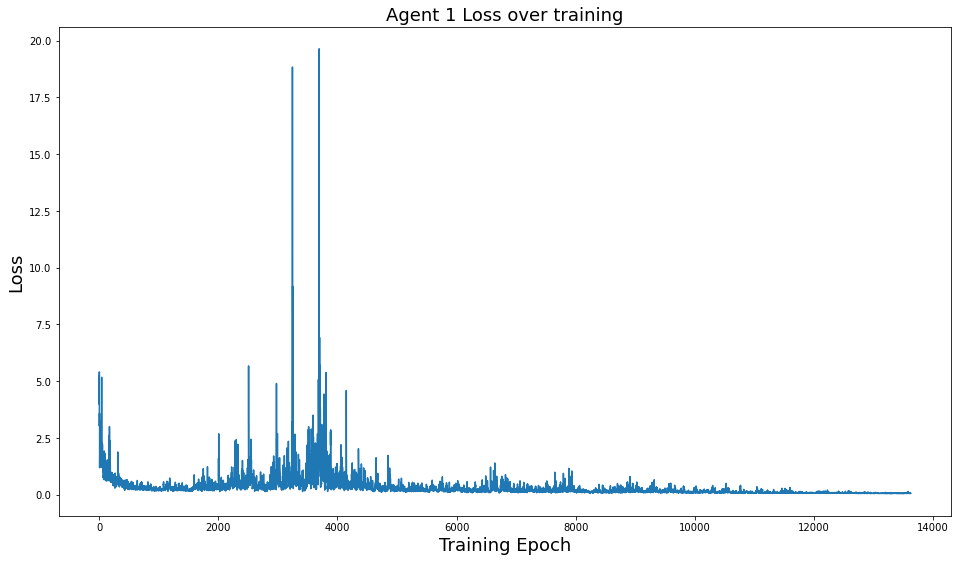

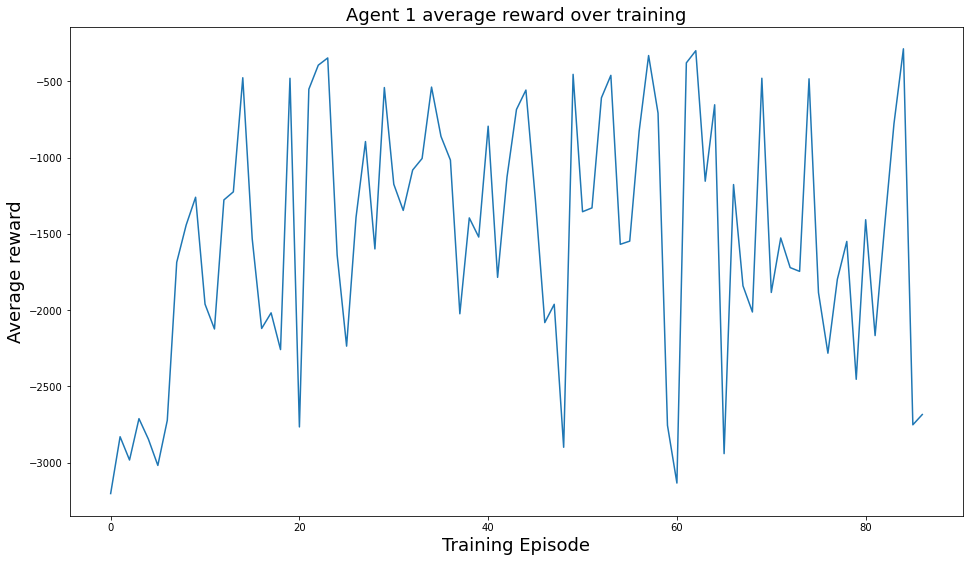

In [15]:
# Training Loop
exams = 0
volume = 400

# Start Environment
Single_Cross_Triple8_MultiDQN_Agents.env = environment(model_name, vissim_working_directory, sim_length,\
                                                       Single_Cross_Triple_dictionary8, actions_set, Random_Seed,\
                                                       timesteps_per_second = timesteps_per_second, mode = 'training',\
                                                       delete_results = True, verbose = True)
# Training Loop
for episode in range(total_episodes):
    # Train and evaluate accordingly to demand levels that generated memories
    if episode > low_demand_limit:
        volume = 600
    elif episode > mid_demand_limit:
        volume = 800
    Single_Cross_Triple8_MultiDQN_Agents.env.change_demand(volume)
    
    # Set up Memory
    print("Round {}/{}: Adding {} memories from Deque into Agent".format(episode, len(partitioned_memory)-1,\
                                                                                       len(partitioned_memory[episode])))
    Single_Cross_Triple8_MultiDQN_Agents.Agents[0].memory = deque(maxlen=memory_size)
    for idx,sarsd in enumerate(partitioned_memory[episode]):
        s = sarsd[0]
        a = sarsd[1]
        r = sarsd[2]
        ns = sarsd[3]
        d = sarsd[4]
        Single_Cross_Triple8_MultiDQN_Agents.Agents[0].remember_external(s,a,r,ns,d)
    
    # Stochastic Gradient Descent on weights
    print("Memories succesfully loaded. Performing SGD on weights...")
    for iteration in range(learning_iterations):
        Single_Cross_Triple8_MultiDQN_Agents.Agents[0].learn_batch(128, 1)
    
    # Every 20 iterations, copy weights
    if episode%copy_weights_frequency == 0:
        Single_Cross_Triple8_MultiDQN_Agents.Agents[0].copy_weights()
    # Every so often, check agent performance
    if episode%exam_frequency == 0:
        print("Starting exam run...")
        exams += 1
        Single_Cross_Triple8_MultiDQN_Agents.external_training()

# After all memories are processed, check agent performance one last time, close environment, plot training and save.
Single_Cross_Triple8_MultiDQN_Agents.external_training()
Single_Cross_Triple8_MultiDQN_Agents.env = None
plot_results_train()
Single_Cross_Triple8_MultiDQN_Agents.save(len(partitioned_memory))

In [ ]:
Single_Cross_Triple8_MultiDQN_Agents.load(len(partitioned_memory), best=False)

In [ ]:
len(partitioned_memory)

In [ ]:
Single_Cross_Triple8_MultiDQN_Agents.demo()

In [ ]:
# Perform Evaluation
print("\n" + "Starting final exams...")
for repetition in range(3*final_exams):
    if repetition < final_exams:
        volume = 400
    elif repetition >= final_exams and repetition < (2*final_exams):
        volume = 600
    elif repetition >= (2*final_exams):
        volume = 800
        
    Single_Cross_Triple8_MultiDQN_Agents.test_demand(volume)
    plot_results_test(str(volume)+"_"+str(repetition))


In [ ]:
from csv import reader

demand = 400


storage05 = np.zeros((10,3599))
storage85 = np.zeros((10,3599))
storage95 = np.zeros((10,3599))

for i in range(10):
    folder05 = "C:\\Users\\acabrejasegea\Desktop\\15_Timescales_utc\\Timescales_and_Discount_Factor_in_UTC\\Single_Cross_Triple\\Agents_Results\\DuelingDDQN\\SCT_8ac_MemGen_Q_2_Res_Gamma05\\"
    folder85 = "C:\\Users\\acabrejasegea\Desktop\\15_Timescales_utc\\Timescales_and_Discount_Factor_in_UTC\\Single_Cross_Triple\\Agents_Results\\DuelingDDQN\\SCT_8ac_MemGen_Q_2_Res_Gamma85\\"
    folder95 = "C:\\Users\\acabrejasegea\Desktop\\15_Timescales_utc\\Timescales_and_Discount_Factor_in_UTC\\Single_Cross_Triple\\Agents_Results\\DuelingDDQN\\SCT_8ac_MemGen_Q_2_Res_Gamma95\\"

    file = "Junction0_Cumulative_Delay_"
    
    with open(folder05+file+str(demand)+"_{}.csv".format(i), 'r') as read_obj:
        csv_reader = reader(read_obj)
        temp = list(csv_reader)
        delay = [float(temp[idx][1]) for idx in range(1,3600)]
        storage05[i,:] = delay   
        
    with open(folder85+file+str(demand)+"_{}.csv".format(i), 'r') as read_obj:
        csv_reader = reader(read_obj)
        temp = list(csv_reader)
        delay = [float(temp[idx][1]) for idx in range(1,3600)]
        storage85[i,:] = delay
            
    with open(folder95+file+str(demand)+"_{}.csv".format(i), 'r') as read_obj:
        csv_reader = reader(read_obj)
        temp = list(csv_reader)
        delay = [float(temp[idx][1]) for idx in range(1,3600)]
        storage95[i,:] = delay

plt.plot(np.mean(storage05, axis = 0), label = "\gamma = 55")
plt.plot(np.mean(storage85, axis = 0), label = "\gamma = 85")
plt.plot(np.mean(storage95, axis = 0), label = "\gamma = 95")
plt.legend()

In [ ]:
from csv import reader

demand = 800


storage05 = np.zeros((10,3599))
storage85 = np.zeros((10,3599))
storage95 = np.zeros((10,3599))

for i in range(10):
    folder05 = "C:\\Users\\acabrejasegea\Desktop\\15_Timescales_utc\\Timescales_and_Discount_Factor_in_UTC\\Single_Cross_Triple\\Agents_Results\\DuelingDDQN\\SCT_8ac_MemGen_Q_2_Res_Gamma05\\"
    folder85 = "C:\\Users\\acabrejasegea\Desktop\\15_Timescales_utc\\Timescales_and_Discount_Factor_in_UTC\\Single_Cross_Triple\\Agents_Results\\DuelingDDQN\\SCT_8ac_MemGen_Q_2_Res_Gamma85\\"
    folder95 = "C:\\Users\\acabrejasegea\Desktop\\15_Timescales_utc\\Timescales_and_Discount_Factor_in_UTC\\Single_Cross_Triple\\Agents_Results\\DuelingDDQN\\SCT_8ac_MemGen_Q_2_Res_Gamma95\\"

    file = "Junction0_Cumulative_Delay_"
    
    with open(folder05+file+str(demand)+"_{}.csv".format(i+10), 'r') as read_obj:
        csv_reader = reader(read_obj)
        temp = list(csv_reader)
        delay = [float(temp[idx][1]) for idx in range(1,3600)]
        storage05[i,:] = delay   
        
    with open(folder85+file+str(demand)+"_{}.csv".format(i+10), 'r') as read_obj:
        csv_reader = reader(read_obj)
        temp = list(csv_reader)
        delay = [float(temp[idx][1]) for idx in range(1,3600)]
        storage85[i,:] = delay
            
    with open(folder95+file+str(demand)+"_{}.csv".format(i+10), 'r') as read_obj:
        csv_reader = reader(read_obj)
        temp = list(csv_reader)
        delay = [float(temp[idx][1]) for idx in range(1,3600)]
        storage95[i,:] = delay

plt.plot(np.mean(storage05, axis = 0), label = "\gamma = 55")
plt.plot(np.mean(storage85, axis = 0), label = "\gamma = 85")
plt.plot(np.mean(storage95, axis = 0), label = "\gamma = 95")
plt.legend()

In [ ]:
from csv import reader

demand = 1200


storage05 = np.zeros((10,3599))
storage85 = np.zeros((10,3599))
storage95 = np.zeros((10,3599))

for i in range(10):
    folder05 = "C:\\Users\\acabrejasegea\Desktop\\15_Timescales_utc\\Timescales_and_Discount_Factor_in_UTC\\Single_Cross_Triple\\Agents_Results\\DuelingDDQN\\SCT_8ac_MemGen_Q_2_Res_Gamma05\\"
    folder85 = "C:\\Users\\acabrejasegea\Desktop\\15_Timescales_utc\\Timescales_and_Discount_Factor_in_UTC\\Single_Cross_Triple\\Agents_Results\\DuelingDDQN\\SCT_8ac_MemGen_Q_2_Res_Gamma85\\"
    folder95 = "C:\\Users\\acabrejasegea\Desktop\\15_Timescales_utc\\Timescales_and_Discount_Factor_in_UTC\\Single_Cross_Triple\\Agents_Results\\DuelingDDQN\\SCT_8ac_MemGen_Q_2_Res_Gamma95\\"

    file = "Junction0_Cumulative_Delay_"
    
    with open(folder05+file+str(demand)+"_{}.csv".format(i+20), 'r') as read_obj:
        csv_reader = reader(read_obj)
        temp = list(csv_reader)
        delay = [float(temp[idx][1]) for idx in range(1,3600)]
        storage05[i,:] = delay   
        
    with open(folder85+file+str(demand)+"_{}.csv".format(i+20), 'r') as read_obj:
        csv_reader = reader(read_obj)
        temp = list(csv_reader)
        delay = [float(temp[idx][1]) for idx in range(1,3600)]
        storage85[i,:] = delay
            
    with open(folder95+file+str(demand)+"_{}.csv".format(i+20), 'r') as read_obj:
        csv_reader = reader(read_obj)
        temp = list(csv_reader)
        delay = [float(temp[idx][1]) for idx in range(1,3600)]
        storage95[i,:] = delay

plt.plot(np.mean(storage05, axis = 0), label = "\gamma = 55")
plt.plot(np.mean(storage85, axis = 0), label = "\gamma = 85")
plt.plot(np.mean(storage95, axis = 0), label = "\gamma = 95")
plt.legend()

In [ ]:
t = np.zeros((2,3599))

t[0,:] = a

In [ ]:
plt.plot(t[0,:])

In [ ]:
filename1 = os.path.join(vissim_working_directory, model_name, "Agents_Results", agent_type, "SCT_8ac_MemGen_Q_Range") + "\\memoryD3QN_600.pkl"
print("Attempting to load file:")
print(filename1 + "\n")
initial_memory = list(pickle.load(open(filename1, 'rb')))

In [ ]:
len(initial_memory)